In [242]:
import os
os.chdir("/Users/asahoo/repos/PASTIS")
import time
from shutil import copy

from astropy.io import fits
import astropy.units as u
import hcipy
import numpy as np

import pastis.util as util    
from pastis.config import CONFIG_PASTIS 
from pastis.e2e_simulators.luvoir_imaging import LuvoirA_APLC 
from pastis.e2e_simulators.generic_segmented_telescopes import SegmentedAPLC
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata

import exoscene.image
import exoscene.star
import exoscene.planet
from exoscene.planet import Planet

from astropy.io import fits as pf

### Define and create directory

In [2]:
root_dir = "/Users/asahoo/Desktop/data_repos/harris_data"
repo_dir = "/Users/asahoo/repos/PASTIS"
coronagraph_design = 'small' # user provides
overall_dir = util.create_data_path(root_dir, telescope='luvoir_'+coronagraph_design)
resDir = os.path.join(overall_dir, 'matrix_numerical')
print(resDir)


# Create necessary directories if they don't exist yet
os.makedirs(resDir, exist_ok=True)
os.makedirs(os.path.join(resDir, 'OTE_images'), exist_ok=True)
os.makedirs(os.path.join(resDir, 'psfs'), exist_ok=True)

/Users/asahoo/Desktop/data_repos/harris_data

/Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical


### Read from configfile 

In [3]:
nb_seg = CONFIG_PASTIS.getint('LUVOIR', 'nb_subapertures')
wvln = CONFIG_PASTIS.getfloat('LUVOIR', 'lambda') * 1e-9  # m #this doesn't matter, luvoir.wvln
diam = CONFIG_PASTIS.getfloat('LUVOIR', 'diameter')  # m
nm_aber = CONFIG_PASTIS.getfloat('LUVOIR', 'calibration_aberration') * 1e-9   # m
sampling = CONFIG_PASTIS.getfloat('LUVOIR', 'sampling')
coronagraph_design = CONFIG_PASTIS.get('LUVOIR','coronagraph_design')

optics_path_in_repo = CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo')
aper_path = CONFIG_PASTIS.get('LUVOIR','aperture_path_in_optics')
aper_ind_path = CONFIG_PASTIS.get('LUVOIR', 'indexed_aperture_path_in_optics')
aper_read = hcipy.read_fits(os.path.join(repo_dir,optics_path_in_repo,aper_path))
aper_ind_read = hcipy.read_fits(os.path.join(repo_dir,optics_path_in_repo,aper_ind_path))
z_pup_downsample = CONFIG_PASTIS.getfloat('numerical', 'z_pup_downsample') 

In [218]:
diam?

### Load aperture files to make segmented mirror

In [4]:
pupil_grid = hcipy.make_pupil_grid(dims=aper_ind_read.shape[0], diameter=15)
aper = hcipy.Field(aper_read.ravel(), pupil_grid)
aper_ind = hcipy.Field(aper_ind_read.ravel(), pupil_grid)
wf_aper = hcipy.Wavefront(aper, wvln)

# Load segment positions from fits header
hdr = fits.getheader(os.path.join(repo_dir,optics_path_in_repo,aper_ind_path))

poslist = []
for i in range(nb_seg):
    segname = 'SEG' + str(i+1)
    xin = hdr[segname + '_X']
    yin = hdr[segname + '_Y']
    poslist.append((xin, yin))
    
poslist = np.transpose(np.array(poslist))
seg_pos = hcipy.CartesianGrid(hcipy.UnstructuredCoords(poslist))

/opt/miniconda3/envs/pastis/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


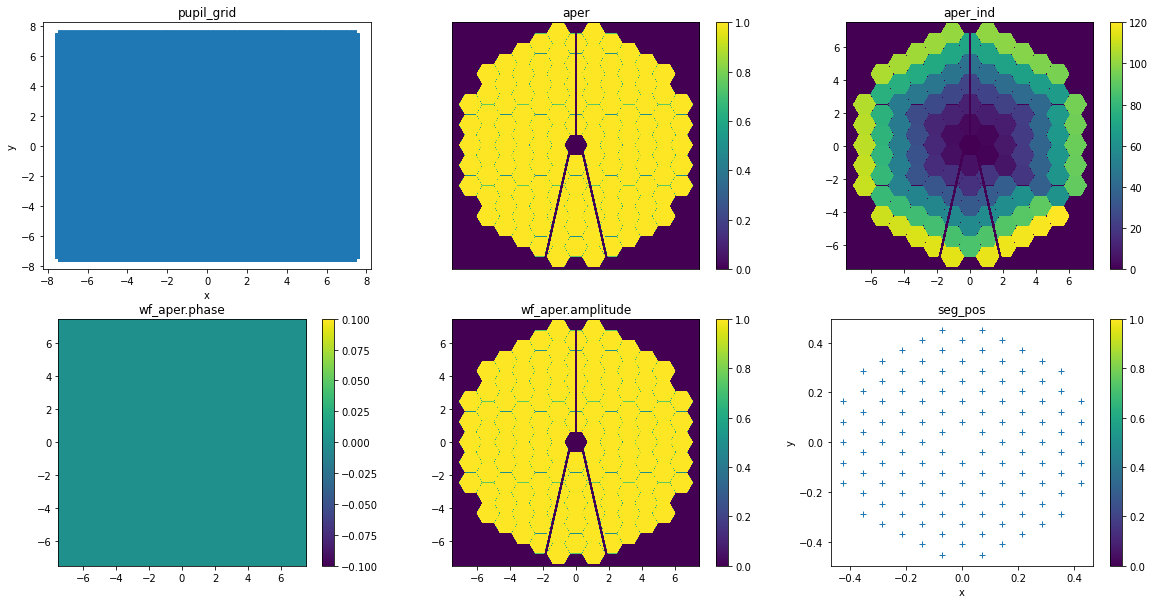

In [5]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.title("pupil_grid")
plt.plot(pupil_grid.x, pupil_grid.y, '+')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(2,3,2)
plt.title("aper")
hcipy.imshow_field(aper)
plt.tick_params(top=False, bottom=False, left=False, right=False,
                labelleft=False, labelbottom=False)
plt.colorbar()

plt.subplot(2,3,3)
plt.title("aper_ind")
hcipy.imshow_field(aper_ind)
plt.colorbar()

plt.subplot(2,3,4)
plt.title("wf_aper.phase")
hcipy.imshow_field(wf_aper.phase)
plt.colorbar()

plt.subplot(2,3,5)
plt.title("wf_aper.amplitude")
hcipy.imshow_field(wf_aper.amplitude)
plt.colorbar()

plt.subplot(2,3,6)
plt.title("seg_pos")
plt.plot(seg_pos.x, seg_pos.y, '+')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

### Instantiate LUVOIR

In [6]:
optics_input = os.path.join(util.find_repo_location(), CONFIG_PASTIS.get('LUVOIR', 'optics_path_in_repo'))
luvoir = LuvoirA_APLC(optics_input, coronagraph_design, sampling)

/opt/miniconda3/envs/pastis/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


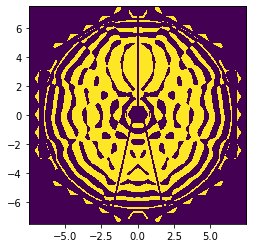

In [7]:
hcipy.imshow_field(luvoir.apodizer)

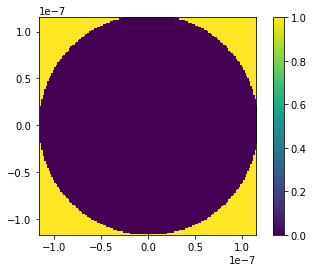

In [8]:
hcipy.imshow_field(luvoir.fpm)
plt.colorbar()

In [9]:
N_pup_z = int(luvoir.pupil_grid.shape[0] / z_pup_downsample) #N_pup_z = 100
grid_zernike = hcipy.field.make_pupil_grid(N_pup_z, diameter=luvoir.diam)

Text(0, 0.5, 'y')

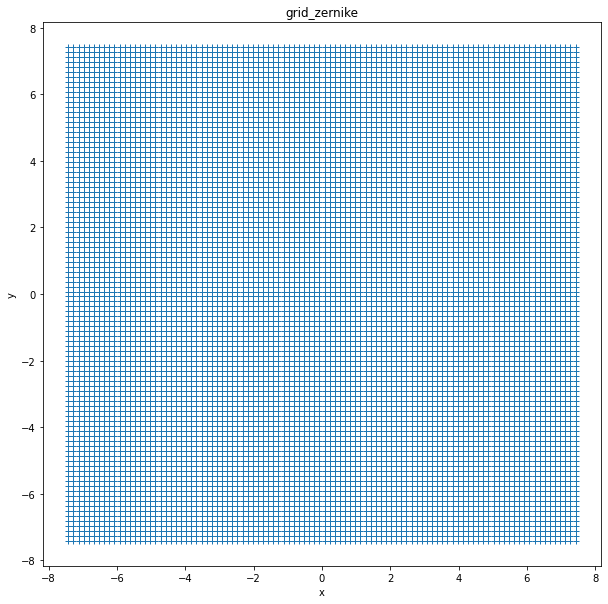

In [10]:
plt.figure(figsize=(10,10))
plt.title("grid_zernike") #hcipy cartesian grid
plt.plot(grid_zernike.x, grid_zernike.y, '+')
plt.xlabel('x')
plt.ylabel('y')

### load thermal modes files

In [11]:
filepath = "/Users/asahoo/Documents/ultra/Sensitivities2.xlsx"
pad_orientation = np.pi/2*np.ones(nb_seg)
#pad_orientation = np.zeros(nb_seg)

### create harris deformabale mirror

In [12]:
luvoir.create_segmented_harris_mirror(filepath,pad_orientation, thermal = True,mechanical=False,other=False) 
luvoir.harris_sm  #how to plot this? #hcipy deformable mirror and returns a wavefront

### creating single segment

In [13]:
segment = hcipy.hexagonal_aperture(luvoir.segment_circumscribed_diameter, np.pi/2) #function
segment_sampled = hcipy.evaluate_supersampled(segment,luvoir.pupil_grid, 10) #hcipy field

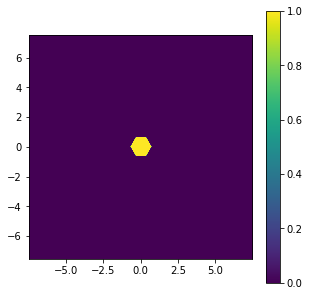

In [14]:
plt.figure(figsize=(5, 5))
hcipy.imshow_field(segment_sampled)
plt.colorbar()

### creating nb_seg segments

In [15]:
aper2, segs2 = hcipy.make_segmented_aperture(segment,luvoir.seg_pos, segment_transmissions=1, return_segments=True)
luvoir_segmented_pattern = hcipy.evaluate_supersampled(aper2, luvoir.pupil_grid, 10) #plot with hcipy.imshow_field
seg_evaluated = []
for seg_tmp in segs2:
    tmp_evaluated = hcipy.evaluate_supersampled(seg_tmp, luvoir.pupil_grid, 1)
    seg_evaluated.append(tmp_evaluated)

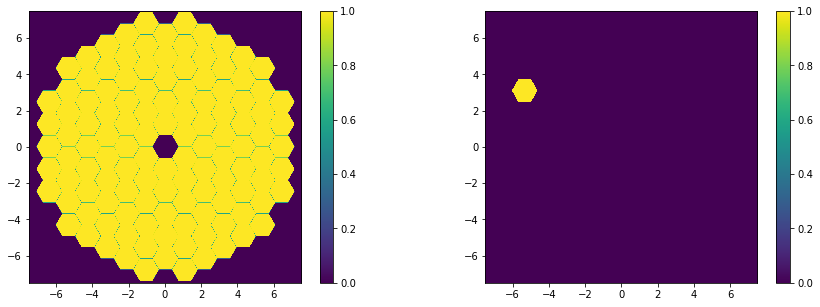

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
hcipy.imshow_field(luvoir_segmented_pattern) #no where used in rest of the code?
plt.colorbar()

plt.subplot(1,2,2)
hcipy.imshow_field(seg_evaluated[75])
plt.colorbar()

### Plotting Harris_mode

In [17]:
df = pd.read_excel(filepath) #this code is already in repo; find ways to reduce the number of lines 
valuesA = np.asarray(df.a)
valuesB = np.asarray(df.b)
valuesC = np.asarray(df.c)
valuesD = np.asarray(df.d)
valuesE = np.asarray(df.e)
valuesF = np.asarray(df.f)
valuesG = np.asarray(df.g)
valuesH = np.asarray(df.h)
valuesI = np.asarray(df.i)
valuesJ = np.asarray(df.j)
valuesK = np.asarray(df.k)

seg_x = np.asarray(df.X)
seg_y = np.asarray(df.Y)

harris_seg_diameter = np.max([np.max(seg_x) - np.min(seg_x), np.max(seg_y) - np.min(seg_y)])
pup_dims = luvoir.pupil_grid.dims
x_grid = np.asarray(df.X) * luvoir.segment_circumscribed_diameter /harris_seg_diameter
y_grid = np.asarray(df.Y) * luvoir.segment_circumscribed_diameter /harris_seg_diameter
points = np.transpose(np.asarray([x_grid, y_grid]))

seg_evaluated = luvoir._create_evaluated_segment_grid()

def _transform_harris_mode(values, xrot, yrot, points, seg_evaluated, seg_num):
    """ Take imported Harris mode data and transform into a segment mode on our aperture. """
    zval = griddata(points, values, (xrot, yrot), method='linear')
    zval[np.isnan(zval)] = 0
    zval = zval.ravel() * seg_evaluated[seg_num]
    return zval

harris_base_thermal = []
for seg_num in range(0, luvoir.nseg):
    grid_seg = luvoir.pupil_grid.shifted(-luvoir.seg_pos[seg_num])
    x_line_grid = np.asarray(grid_seg.x)
    y_line_grid = np.asarray(grid_seg.y)
    
# Rotate the modes grids according to the orientation of the mounting pads
phi = pad_orientation[seg_num]
x_rotation = x_line_grid * np.cos(phi) + y_line_grid * np.sin(phi)
y_rotation = -x_line_grid * np.sin(phi) + y_line_grid * np.cos(phi)

# Transform all needed Harris modes from data to modes on our segmented aperture
ZA = _transform_harris_mode(valuesA, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZB = _transform_harris_mode(valuesB, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZC = _transform_harris_mode(valuesC, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZD = _transform_harris_mode(valuesD, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZE = _transform_harris_mode(valuesE, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZF = _transform_harris_mode(valuesF, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZG = _transform_harris_mode(valuesG, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZH = _transform_harris_mode(valuesH, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZI = _transform_harris_mode(valuesI, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZJ = _transform_harris_mode(valuesJ, x_rotation, y_rotation, points, seg_evaluated, seg_num)
ZK = _transform_harris_mode(valuesK, x_rotation, y_rotation, points, seg_evaluated, seg_num)

harris_base_thermal.append([ZA, ZB, ZC, ZD, ZE, ZF, ZG, ZH, ZI, ZJ, ZK])

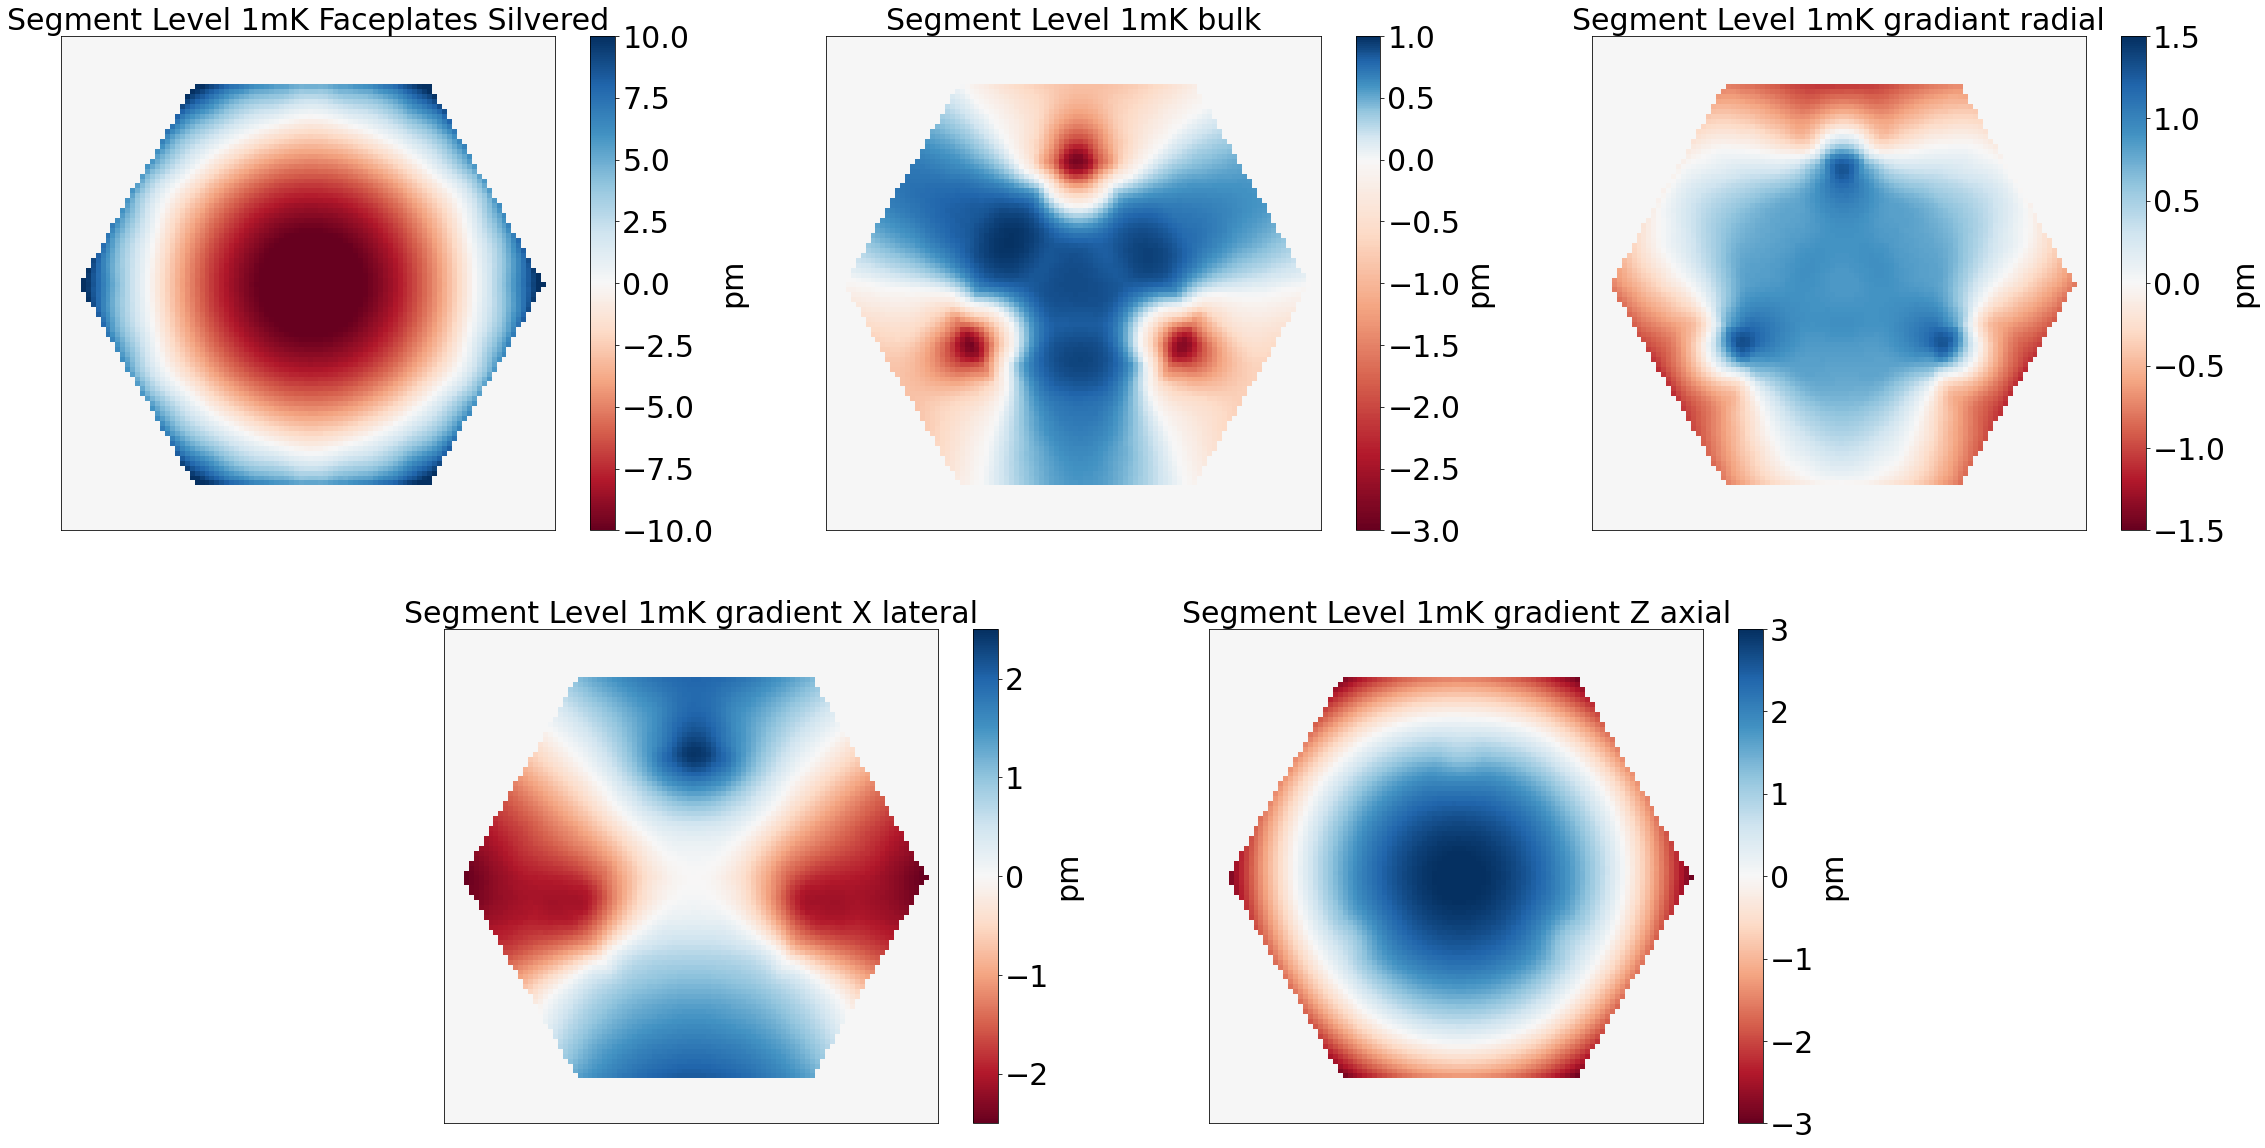

In [216]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec

plot_norm = TwoSlopeNorm(vcenter=0)

plt.figure(figsize=(40,20))
ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.title("Segment Level 1mK Faceplates Silvered", fontsize=30)
plot_norm1 = TwoSlopeNorm(vcenter=0, vmin=-10,  vmax =10)
plt.imshow(np.reshape(ZA,(1000,1000))[163:263,804:904], cmap = 'RdBu', norm = plot_norm1)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)


ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.title("Segment Level 1mK bulk",fontsize=30)
plot_norm2 = TwoSlopeNorm(vcenter=0, vmin=-3,  vmax =1)
plt.imshow(np.reshape(ZH,(1000,1000))[163:263,804:904],cmap = 'RdBu',norm = plot_norm2)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)



ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.title("Segment Level 1mK gradiant radial",fontsize=30)
plot_norm3 = TwoSlopeNorm(vcenter=0, vmin=-1.5,  vmax =1.5) 
plt.imshow(np.reshape(ZI,(1000,1000))[163:263,804:904],cmap = 'RdBu',norm = plot_norm3)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)



ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.title("Segment Level 1mK gradient X lateral",fontsize=30)
plot_norm4 = TwoSlopeNorm(vcenter=0, vmin=-2.5,  vmax =2.5) #
plt.imshow(np.reshape(ZJ,(1000,1000))[163:263,804:904],cmap = 'RdBu', norm = plot_norm4)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)



ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.title("Segment Level 1mK gradient Z axial",fontsize=30)
plot_norm5 = TwoSlopeNorm(vcenter=0,vmin=-3,  vmax =3)
plt.imshow(np.reshape(ZK,(1000,1000))[163:263,804:904],cmap = 'RdBu', norm = plot_norm5)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)

#plt.tight_layout()
plt.savefig('/Users/asahoo/Documents/ultra/report_11_01_21/thermal_basis.png')

### Single mode plots

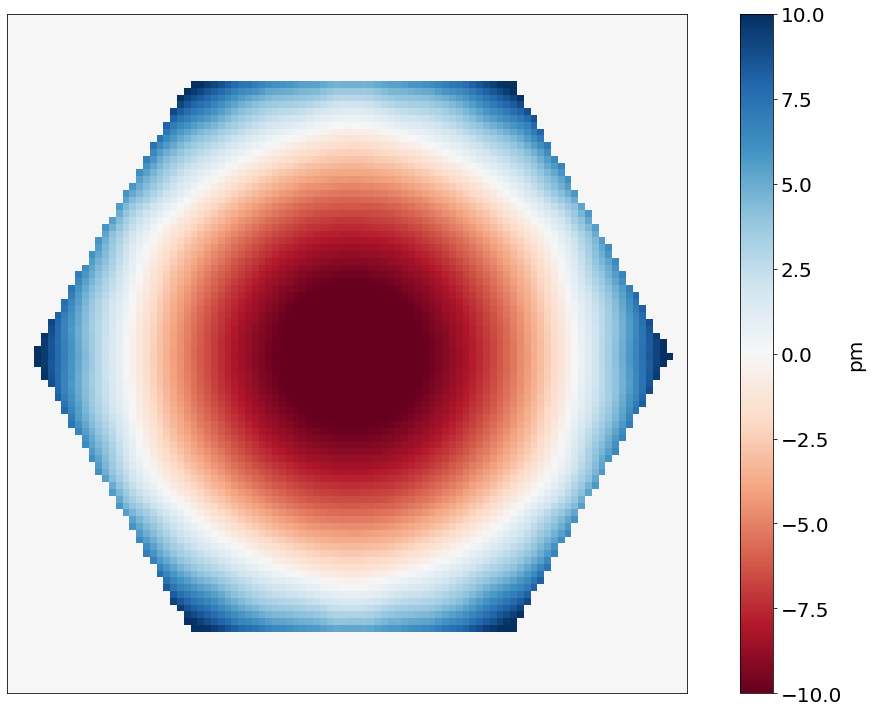

In [190]:
from matplotlib.colors import TwoSlopeNorm

plt.figure(figsize=(15,10))

#plt.title("Segment Level 1mk gradient Z axial",fontsize=20)
plot_norm1 = TwoSlopeNorm(vcenter=0, vmin=-10,  vmax =10)
plt.imshow(np.reshape(ZA,(1000,1000))[163:263,804:904], cmap = 'RdBu', norm = plot_norm1)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
cbar.set_label("pm",fontsize =20)

plt.tight_layout()
plt.savefig('/Users/asahoo/Documents/ultra/report_11_01_21/faceplate_silvered.png')

### Flatten all DMs and create unaberrated reference PSF

In [19]:
n_harris = luvoir.harris_sm.num_actuators #int = 5*120 =600
harris_mode =np.zeros(n_harris)
luvoir.harris_sm.actuators = harris_mode #setting all actuators to be zero

### Calculate the unaberrated coro and direct PSFs in INTENSITY

In [20]:
unaberrated_coro_psf, ref = luvoir.calc_psf(ref=True, display_intermediate=False, norm_one_photon=True)

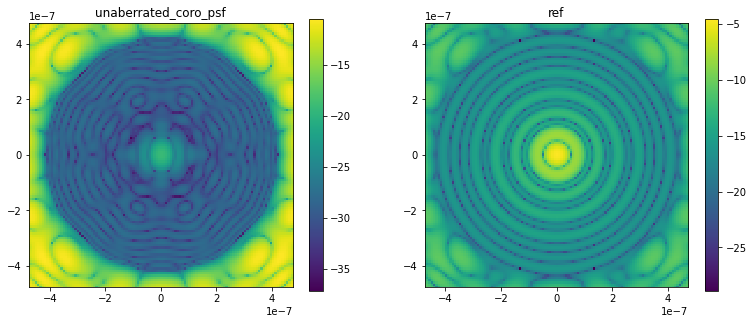

In [21]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title("Non Aberrated Coronagraphic PSF") #hcipy.field
hcipy.imshow_field(np.log(np.abs(unaberrated_coro_psf)))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("PSF without Coronagraph")
hcipy.imshow_field(np.log(np.abs(ref))) #hcipy wavefront
plt.colorbar()

0.010242195657579547
contrast floor: 4.23763607005635e-11


Text(0.5, 1.0, 'dh_intensity')

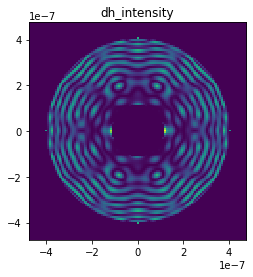

In [22]:
norm = np.max(ref)
print(norm)
dh_intensity = (unaberrated_coro_psf / norm) * luvoir.dh_mask #field,13225 elements
contrast_floor = np.mean(dh_intensity[np.where(luvoir.dh_mask != 0)])
print(f'contrast floor: {contrast_floor}')

hcipy.imshow_field(dh_intensity)
plt.title("dh_intensity")

### Changing the axis scale to $\lambda /D$

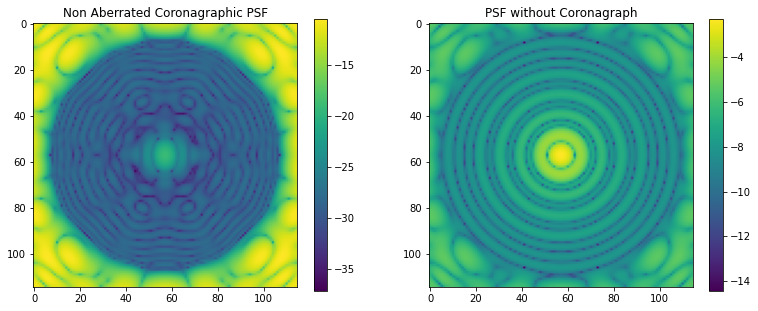

In [244]:
ideal_coro_psf = np.reshape(unaberrated_coro_psf, [115,115])
ideal_psf = np.reshape(ref.electric_field, [115,115])

pf.writeto('/Users/asahoo/Documents/ultra/report_11_01_21/ideal_psf.fits', np.abs(ideal_psf))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.title("Non Aberrated Coronagraphic PSF")
plt.imshow(np.log(np.abs(ideal_coro_psf)))
plt.colorbar()

plt.subplot(1,2,2)
plt.title("PSF without Coronagraph")
plt.imshow(np.log(np.abs(ideal_psf)))
plt.colorbar()


In [240]:
ind_max = np.unravel_index(np.argmax(np.abs(ideal_psf), axis=None), np.abs(ideal_psf).shape)
print(ind_max)

(57, 57)


### Calculate the unaberrated coro and direct PSFs in E-FIELDS

In [23]:
# Calculate the unaberrated coro and direct PSFs in E-FIELDS
nonaberrated_coro_psf, ref, efield = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
Efield_ref = nonaberrated_coro_psf.electric_field

In [24]:
dh_intensity_nonaberrated = ((np.square(nonaberrated_coro_psf.amplitude))/ norm) * luvoir.dh_mask #field,13225 elements
contrast_floor_nonberrated = np.mean(dh_intensity_nonaberrated[np.where(luvoir.dh_mask != 0)])
print(f'contrast floor: {contrast_floor_nonberrated}')

contrast floor: 4.23763607005635e-11


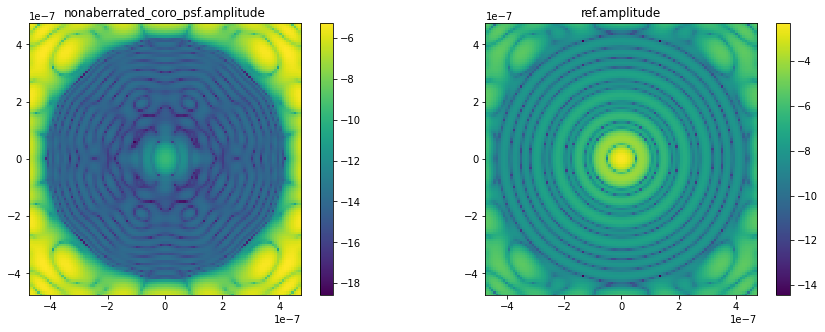

In [25]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
hcipy.imshow_field(np.log(np.abs(nonaberrated_coro_psf.amplitude)))
plt.title("nonaberrated_coro_psf.amplitude")
plt.colorbar()

plt.subplot(1,2,2)
hcipy.imshow_field(np.log(np.abs(ref.amplitude)))
plt.title("ref.amplitude")
plt.colorbar()

In [26]:
print('Generating the E-fields for harris modes in science plane')
print(f'Calibration aberration used: {nm_aber} m')


Generating the E-fields for harris modes in science plane
Calibration aberration used: 1e-09 m


In [27]:
start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []
#harris_mode = np.zeros(n_harris)

for pp in range(0, n_harris):
    print(f'Working on mode {pp}/{n_harris}')
    
    # Apply calibration aberration to used mode
    harris_mode = np.zeros(n_harris)
    harris_mode[pp] = (nm_aber)/2 
    luvoir.harris_sm.actuators  = harris_mode
    
    # Calculate coronagraphic E-field and add to lists
    aberrated_coro_psf, inter = luvoir.calc_psf(display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
    focus_field1 = aberrated_coro_psf
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

Working on mode 0/600
Working on mode 1/600
Working on mode 2/600
Working on mode 3/600
Working on mode 4/600
Working on mode 5/600
Working on mode 6/600
Working on mode 7/600
Working on mode 8/600
Working on mode 9/600
Working on mode 10/600
Working on mode 11/600
Working on mode 12/600
Working on mode 13/600
Working on mode 14/600
Working on mode 15/600
Working on mode 16/600
Working on mode 17/600
Working on mode 18/600
Working on mode 19/600
Working on mode 20/600
Working on mode 21/600
Working on mode 22/600
Working on mode 23/600
Working on mode 24/600
Working on mode 25/600
Working on mode 26/600
Working on mode 27/600
Working on mode 28/600
Working on mode 29/600
Working on mode 30/600
Working on mode 31/600
Working on mode 32/600
Working on mode 33/600
Working on mode 34/600
Working on mode 35/600
Working on mode 36/600
Working on mode 37/600
Working on mode 38/600
Working on mode 39/600
Working on mode 40/600
Working on mode 41/600
Working on mode 42/600
Working on mode 43/60

Working on mode 346/600
Working on mode 347/600
Working on mode 348/600
Working on mode 349/600
Working on mode 350/600
Working on mode 351/600
Working on mode 352/600
Working on mode 353/600
Working on mode 354/600
Working on mode 355/600
Working on mode 356/600
Working on mode 357/600
Working on mode 358/600
Working on mode 359/600
Working on mode 360/600
Working on mode 361/600
Working on mode 362/600
Working on mode 363/600
Working on mode 364/600
Working on mode 365/600
Working on mode 366/600
Working on mode 367/600
Working on mode 368/600
Working on mode 369/600
Working on mode 370/600
Working on mode 371/600
Working on mode 372/600
Working on mode 373/600
Working on mode 374/600
Working on mode 375/600
Working on mode 376/600
Working on mode 377/600
Working on mode 378/600
Working on mode 379/600
Working on mode 380/600
Working on mode 381/600
Working on mode 382/600
Working on mode 383/600
Working on mode 384/600
Working on mode 385/600
Working on mode 386/600
Working on mode 

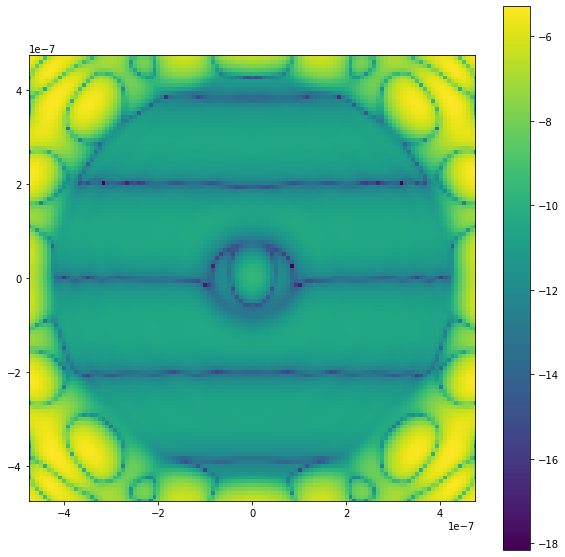

In [28]:
plt.figure(figsize=(10, 10))
hcipy.imshow_field(np.log(np.abs(focus_fieldS_Im[10])))
plt.colorbar()

### Construct the PASTIS matrix from the E-fields

In [29]:
mat_fast = np.zeros([n_harris, n_harris])   # create empty matrix

for i in range(0, n_harris):
    for j in range(0, n_harris):
        test = np.real((focus_fieldS[i].electric_field - Efield_ref) * np.conj(focus_fieldS[j].electric_field - Efield_ref))
        dh_test = (test / norm) * luvoir.dh_mask
        contrast = np.mean(dh_test[np.where(luvoir.dh_mask != 0)])
        mat_fast[i, j] = contrast

In [30]:
matrix_pastis = np.copy(mat_fast)
matrix_pastis /= np.square(nm_aber * 1e9)

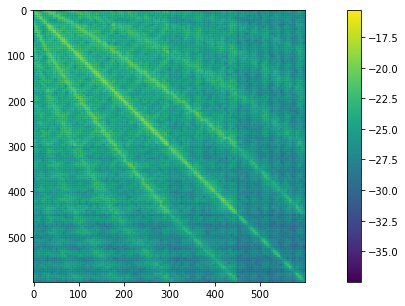

In [31]:
plt.figure(figsize=(15,5))

#plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(mat_fast)))
#plt.title("PASTIS matrix")
#plt.savefig('/Users/asahoo/Desktop/P_matrix.png')
plt.colorbar()

# plt.subplot(1,2,2)
# plt.imshow(np.log(np.abs(matrix_pastis)))
# plt.title("np.log(np.abs(matrix_pastis))")
# plt.colorbar()

In [32]:
filename_matrix = 'PASTISmatrix_n_harris_' + str(n_harris)
hcipy.write_fits(matrix_pastis, os.path.join(resDir, filename_matrix + '.fits'))
print('Matrix saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Matrix saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical/PASTISmatrix_n_harris_600.fits


In [33]:
filename_matrix = 'EFIELD_Re_matrix_n_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Efield Real saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical/EFIELD_Re_matrix_n_harris_600.fits


In [34]:
filename_matrix = 'EFIELD_Im_matrix_n_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Efield Imag saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical/EFIELD_Im_matrix_n_harris_600.fits


In [35]:
end_time = time.time()

In [36]:
print('Runtime for harris modes:', end_time - start_time, 'sec =', (end_time - start_time) / 60, 'min')
print('Data saved to {}'.format(resDir))

Runtime for harris modes: 332.87626028060913 sec = 5.547937671343486 min
Data saved to /Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical


## error analysis

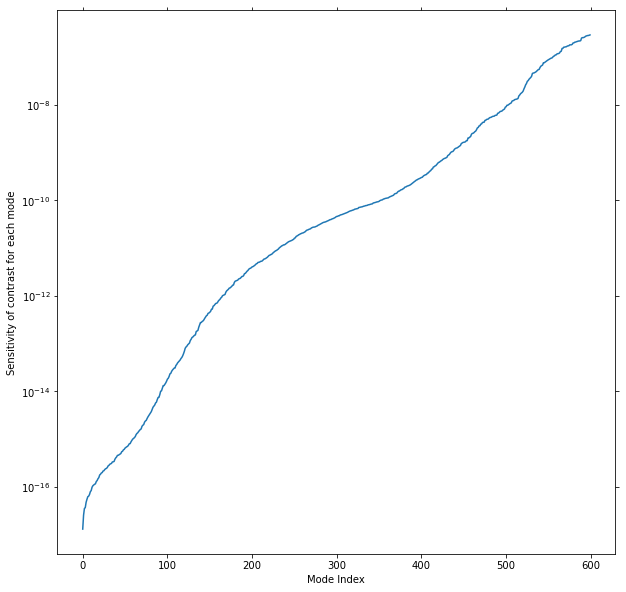

In [37]:
evals, evecs = np.linalg.eig(matrix_pastis)
sorted_evals = np.sort(evals)
sorted_indices = np.argsort(evals)
sorted_evecs = evecs[:, sorted_indices]
plt.figure(figsize=(10, 10))
#plt.plot(evals, label='Unsorted from eigendecomposition')
plt.plot(sorted_evals)
plt.semilogy()
plt.xlabel('Mode Index')
plt.ylabel('Sensitivity of contrast for each mode')
plt.tick_params(top=True, bottom=True, left=True, right=True,
                labelleft=True, labelbottom=True)
#plt.legend()

In [38]:
# emodes = []
# eunit = 1e-9
# for mode in range(len(evals)):
#     print('Working on mode {}/{}.'.format(mode+1, len(evals)))
    
#     harris_coeffs = eunit*sorted_evecs[:, mode]/2
#     luvoir.harris_sm.actuators = harris_coeffs
#     wf_harris_sm = luvoir.harris_sm(luvoir.wf_aper)
#     emodes.append(wf_harris_sm.phase)

In [39]:
c_target_log = -11
c_target = 10**(c_target_log)
n_repeat = 20

In [40]:
mu_map_harris = np.sqrt(((c_target) / (n_harris)) / (np.diag(matrix_pastis)))

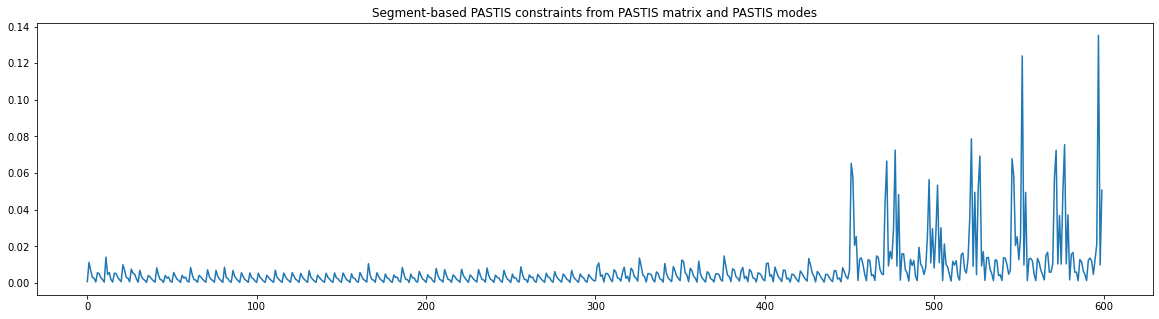

In [41]:
plt.figure(figsize=(20,5))
plt.title("Segment-based PASTIS constraints from PASTIS matrix and PASTIS modes")
plt.plot(mu_map_harris)


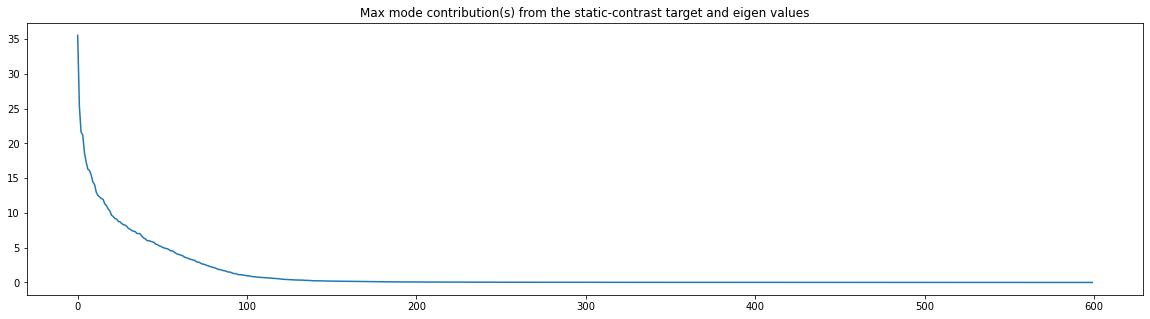

In [42]:
sigma = np.sqrt(((c_target)) / (600 * sorted_evals))
plt.figure(figsize=(20,5))
plt.title("Max mode contribution(s) from the static-contrast target and eigen values")
plt.plot(sigma)

In [43]:
cont_cum_pastis = []
for maxmode in range(sorted_evecs.shape[0]):
    
    aber = np.nansum(sorted_evecs[:, :maxmode+1] * sigma[:maxmode+1], axis=1)
    aber *= u.nm
    contrast_matrix = util.pastis_contrast(aber, matrix_pastis) + contrast_floor
    cont_cum_pastis.append(contrast_matrix)


Text(0, 0.5, 'List of cumulative contrast')

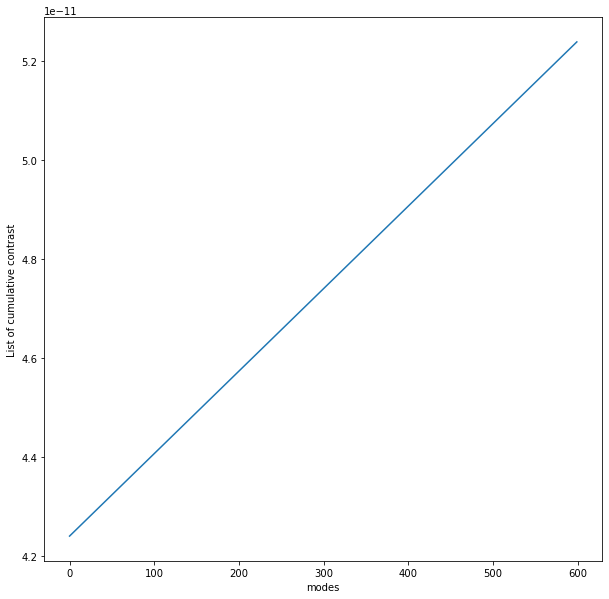

In [44]:
plt.figure(figsize=(10,10))
plt.plot(cont_cum_pastis)
plt.xlabel("modes")
plt.ylabel("List of cumulative contrast")

In [45]:
cont_ind_pastis = []
for maxmode in range(sorted_evecs.shape[0]):
    aber = sorted_evecs[:, maxmode] * sigma[maxmode]
    aber *=u.nm
    contrast_matrix = util.pastis_contrast(aber, matrix_pastis)
    cont_ind_pastis.append(contrast_matrix)

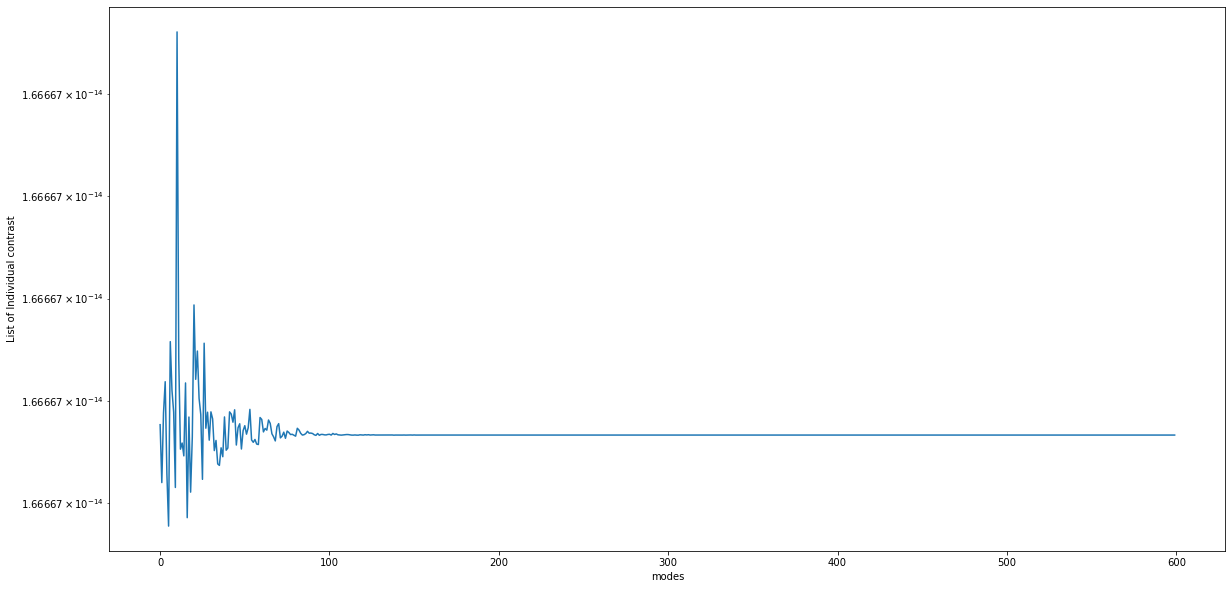

In [46]:
plt.figure(figsize=(20,10))
plt.plot((cont_ind_pastis))
plt.xlabel("modes")
plt.ylabel("List of Individual contrast")
plt.yscale('log')


In [47]:
npup = int(np.sqrt(luvoir.pupil_grid.x.shape[0]))
nimg = int(np.sqrt(luvoir.focal_det.x.shape[0]))

# Getting the flux together
sptype = 'A0V' # Put this on config
Vmag = 0.0 # Put this in loop
minlam = 500 * u.nanometer # Put this on config
maxlam = 600 * u.nanometer # Put this on config
star_flux = exoscene.star.bpgs_spectype_to_photonrate(spectype=sptype, Vmag=Vmag, minlam=minlam.value, maxlam=maxlam.value)
Nph = star_flux.value*15**2*np.sum(luvoir.apodizer**2) / npup**2
dark_current = 0#0.000072 #es per s 
CIC = 0#0.00076 #electrons per sec

In [48]:
harris_mode = np.zeros(n_harris)
luvoir.harris_sm.actuators  = harris_mode
nonaberrated_coro_psf, refshit,inter_ref = luvoir.calc_psf(ref=True, display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
Efield_ref = nonaberrated_coro_psf.electric_field

In [49]:
harris_mode = np.zeros(n_harris)
luvoir.harris_sm.actuators  = harris_mode
harris_ref2 = luvoir.calc_out_of_band_wfs(norm_one_photon=True)
harris_ref2_sub_real = hcipy.field.subsample_field(harris_ref2.real, z_pup_downsample, grid_zernike, statistic='mean')
harris_ref2_sub_imag = hcipy.field.subsample_field(harris_ref2.imag, z_pup_downsample, grid_zernike, statistic='mean')
Efield_ref_OBWFS = (harris_ref2_sub_real + 1j*harris_ref2_sub_imag) * z_pup_downsample

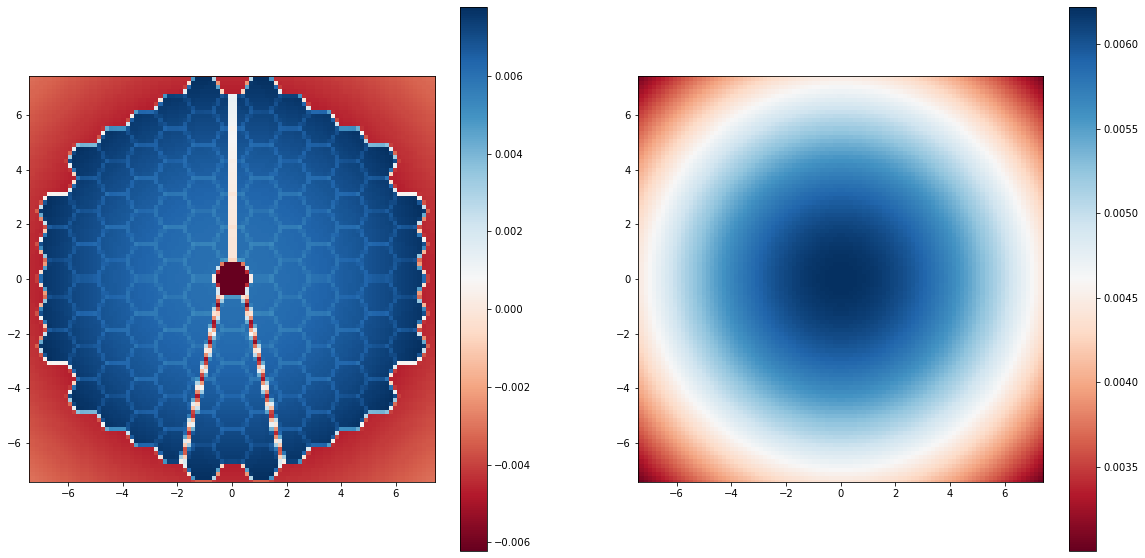

In [50]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
hcipy.imshow_field(Efield_ref_OBWFS.real, cmap ='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
hcipy.imshow_field(Efield_ref_OBWFS.imag, cmap ='RdBu')
plt.colorbar()

In [51]:
nyquist_sampling = 2.

# Actual grid for LUVOIR images
grid_test = hcipy.make_focal_grid(
            luvoir.sampling,
            luvoir.imlamD,
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )

# Actual grid for LUVOIR images that are nyquist sampled
grid_det_subsample = hcipy.make_focal_grid(
            nyquist_sampling,
            np.floor(luvoir.imlamD),
            pupil_diameter=luvoir.diam,
            focal_length=1,
            reference_wavelength=luvoir.wvln,
        )
n_nyquist = np.int(np.sqrt(grid_det_subsample.x.shape[0]))

/opt/miniconda3/envs/pastis/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [52]:
### Dark hole mask
design = 'small'

dh_outer_nyquist = hcipy.circular_aperture(2 * luvoir.apod_dict[design]['owa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_inner_nyquist = hcipy.circular_aperture(2 * luvoir.apod_dict[design]['iwa'] * luvoir.lam_over_d)(grid_det_subsample)
dh_mask_nyquist = (dh_outer_nyquist - dh_inner_nyquist).astype('bool')

dh_size = len(np.where(luvoir.dh_mask != 0)[0])
dh_size_nyquist = len(np.where(dh_mask_nyquist != 0)[0])
dh_index = np.where(luvoir.dh_mask != 0)[0]
dh_index_nyquist = np.where(dh_mask_nyquist != 0)[0]

In [53]:
# E0_LOWFS = np.zeros([N_pup_z*N_pup_z,1,2])
# E0_LOWFS[:,0,0] = Efield_ref_LOWFS.real
# E0_LOWFS[:,0,1] = Efield_ref_LOWFS.imag
E0_OBWFS = np.zeros([N_pup_z*N_pup_z,1,2])
E0_OBWFS[:,0,0] = Efield_ref_OBWFS.real
E0_OBWFS[:,0,1] = Efield_ref_OBWFS.imag
E0_coron = np.zeros([nimg*nimg,1,2])
E0_coron[:,0,0] = Efield_ref.real
E0_coron[:,0,1] = Efield_ref.imag
E0_coron_nyquist = np.zeros([n_nyquist*n_nyquist,1,2])
tmp0 = hcipy.interpolation.make_linear_interpolator_separated(Efield_ref, grid=grid_test)
Efield_ref_nyquist = (luvoir.sampling/nyquist_sampling)**2*tmp0(grid_det_subsample)
E0_coron_nyquist[:,0,0] = Efield_ref_nyquist.real
E0_coron_nyquist[:,0,1] = Efield_ref_nyquist.imag
E0_coron_DH = np.zeros([dh_size,1,2])
E0_coron_DH[:,0,0] = Efield_ref.real[dh_index]
E0_coron_DH[:,0,1] = Efield_ref.imag[dh_index]
E0_coron_DH_nyquist = np.zeros([dh_size_nyquist,1,2])
E0_coron_DH_nyquist[:,0,0] = Efield_ref_nyquist.real[dh_index_nyquist]
E0_coron_DH_nyquist[:,0,1] = Efield_ref_nyquist.real[dh_index_nyquist]

In [54]:
filename_matrix = 'EFIELD_Re_matrix_n_harris_' + str(n_harris) + '.fits'
G_harris_real = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))
filename_matrix = 'EFIELD_Im_matrix_n_harris_' + str(n_harris) + '.fits'
G_harris_imag = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))

G_coron_harris_nyquist= np.zeros([n_nyquist*n_nyquist,2,n_harris])
for pp in range(0, n_harris):
    tmp0 = G_harris_real[pp] + 1j*G_harris_imag[pp]
    tmp1 = hcipy.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp1(grid_det_subsample)
    G_coron_harris_nyquist[:,0,pp] = tmp2.real - Efield_ref_nyquist.real
    G_coron_harris_nyquist[:,1,pp] = tmp2.real - Efield_ref_nyquist.imag

In [55]:
G_coron_harris_DH= np.zeros([dh_size,2,n_harris])
for pp in range(0, n_harris):
    G_coron_harris_DH[:,0,pp] = G_harris_real[pp,dh_index] - Efield_ref.real[dh_index]
    G_coron_harris_DH[:,1,pp] = G_harris_imag[pp,dh_index] - Efield_ref.imag[dh_index]

In [56]:
G_coron_harris_DH_nyquist= np.zeros([dh_size_nyquist,2,n_harris])
for pp in range(0, n_harris):
    tmp0 = G_harris_real[pp] + 1j*G_harris_imag[pp]
    tmp1 = hcipy.interpolation.make_linear_interpolator_separated(tmp0, grid=grid_test)
    tmp2 = (luvoir.sampling/nyquist_sampling)**2*tmp1(grid_det_subsample)
    G_coron_harris_DH_nyquist[:,0,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.real[dh_index_nyquist]
    G_coron_harris_DH_nyquist[:,1,pp-1] = tmp2.real[dh_index_nyquist] - Efield_ref_nyquist.imag[dh_index_nyquist]

In [57]:
G_coron_harris= np.zeros([nimg*nimg,2,n_harris])
for pp in range(0, n_harris):
    G_coron_harris[:,0,pp] = G_harris_real[pp] - Efield_ref.real
    G_coron_harris[:,1,pp] = G_harris_imag[pp] - Efield_ref.imag

In [58]:
start_time = time.time()
focus_fieldS = []
focus_fieldS_Re = []
focus_fieldS_Im = []

In [59]:
for pp in range(0, n_harris):
    print(pp)
    harris_modes = np.zeros(n_harris)
    harris_modes[pp] = (nm_aber) / 2
    luvoir.harris_sm.actuators  = harris_modes
    harris_meas = luvoir.calc_out_of_band_wfs(norm_one_photon=True)
    harris_meas_sub_real = hcipy.field.subsample_field(harris_meas.real, z_pup_downsample, grid_zernike, statistic='mean')
    harris_meas_sub_imag = hcipy.field.subsample_field(harris_meas.imag, z_pup_downsample, grid_zernike, statistic='mean')
    focus_field1 = harris_meas_sub_real + 1j * harris_meas_sub_imag
    focus_fieldS.append(focus_field1)
    focus_fieldS_Re.append(focus_field1.real)
    focus_fieldS_Im.append(focus_field1.imag)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [60]:
filename_matrix = 'EFIELD_OBWFS_Re_matrix_num_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Re, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Real saved to:', os.path.join(resDir, filename_matrix + '.fits'))

filename_matrix = 'EFIELD_OBWFS_Im_matrix_num_harris_' + str(n_harris)
hcipy.write_fits(focus_fieldS_Im, os.path.join(resDir, filename_matrix + '.fits'))
print('Efield Imag saved to:', os.path.join(resDir, filename_matrix + '.fits'))

Efield Real saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical/EFIELD_OBWFS_Re_matrix_num_harris_600.fits
Efield Imag saved to: /Users/asahoo/Desktop/data_repos/harris_data/2021-10-19T07-56-32_luvoir_small/matrix_numerical/EFIELD_OBWFS_Im_matrix_num_harris_600.fits


In [61]:
filename_matrix = 'EFIELD_OBWFS_Re_matrix_num_harris_' + str(n_harris)+'.fits'
G_OBWFS_real = fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))
filename_matrix = 'EFIELD_OBWFS_Im_matrix_num_harris_' + str(n_harris)+'.fits'
G_OBWFS_imag =  fits.getdata(os.path.join(overall_dir, 'matrix_numerical', filename_matrix))

In [62]:
G_OBWFS= np.zeros([N_pup_z*N_pup_z,2,n_harris])
for pp in range(0, n_harris):
    G_OBWFS[:,0,pp] = G_OBWFS_real[pp]*z_pup_downsample - Efield_ref_OBWFS.real
    G_OBWFS[:,1,pp] = G_OBWFS_imag[pp]*z_pup_downsample - Efield_ref_OBWFS.imag

In [63]:
def req_closedloop_calc_recursive(Gcoro, Gsensor, E0coro, E0sensor, Dcoro, Dsensor, t_exp, flux, Q, Niter, dh_mask,
                                  norm):
    P = np.zeros(Q.shape)  # WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    # Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter, r])
    averaged_hist = np.zeros(Niter)
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P + Q * t_exp).reshape((1, 1, r))  # random modes
        G_eps = np.sum(Gsensor * eps, axis=2).reshape((N, 1, 2 * c)) + E0sensor  # electric field
        G_eps_squared = np.sum(G_eps * G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G / np.sqrt(G_eps_squared + Dsensor / flux / t_exp)  # trick to save RAM
        cal_I = 4 * flux * t_exp * np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled)  # information matrix
        P = np.linalg.inv(np.linalg.inv(P + Q * t_exp / 2) + cal_I)
        #         P = np.linalg.inv(cal_I)

        # Coronagraph
        G_eps_coron = np.sum(Gcoro * eps, axis=2).reshape((N_img, 1, 2 * c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron * G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared * flux * t_exp + Dcoro

        # Wavefront sensor
        intensity_WFS = G_eps_squared * flux * t_exp + Dsensor

        # Archive
        test_DH0 = intensity[:, 0, 0] * luvoir.dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH / flux / t_exp / norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS) / flux
        cal_I_hist[pp] = np.mean(cal_I) / flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
        #         print("est. contrast", np.mean(contrasts))

        outputs = {'intensity_WFS_hist': intensity_WFS_hist,
                   'cal_I_hist': cal_I_hist,
                   'eps_hist': eps_hist,
                   'averaged_hist': averaged_hist,
                   'contrasts': contrasts}
    return outputs

In [64]:
def req_closedloop_calc_batch(Gcoro, Gsensor, E0coro, E0sensor, Dcoro, Dsensor, t_exp, flux, Q, Niter, dh_mask, norm):
    P = np.zeros(Q.shape)  # WFE modes covariance estimate
    r = Gsensor.shape[2]
    N = Gsensor.shape[0]
    N_img = Gcoro.shape[0]
    c = 1
    # Iterations of ALGORITHM 1
    contrast_hist = np.zeros(Niter)
    intensity_WFS_hist = np.zeros(Niter)
    cal_I_hist = np.zeros(Niter)
    eps_hist = np.zeros([Niter, r])
    averaged_hist = np.zeros(Niter)
    contrasts = []
    for pp in range(Niter):
        eps = np.random.multivariate_normal(np.zeros(r), P + Q * t_exp).reshape((1, 1, r))  # random modes
        G_eps = np.sum(Gsensor * eps, axis=2).reshape((N, 1, 2 * c)) + E0sensor  # electric field
        G_eps_squared = np.sum(G_eps * G_eps, axis=2, keepdims=True)
        G_eps_G = np.matmul(G_eps, Gsensor)
        G_eps_G_scaled = G_eps_G / np.sqrt(G_eps_squared + Dsensor / flux / t_exp)  # trick to save RAM
        cal_I = 4 * flux * t_exp * np.einsum("ijk,ijl->kl", G_eps_G_scaled, G_eps_G_scaled)  # information matrix
        #         P = np.linalg.inv(np.linalg.inv(P+Q*t_exp/2) + cal_I)
        P = np.linalg.pinv(cal_I)

        # Coronagraph
        G_eps_coron = np.sum(Gcoro * eps, axis=2).reshape((N_img, 1, 2 * c)) + E0coro
        G_eps_coron_squared = np.sum(G_eps_coron * G_eps_coron, axis=2, keepdims=True)
        intensity = G_eps_coron_squared * flux * t_exp + Dcoro

        # Wavefront sensor
        intensity_WFS = G_eps_squared * flux * t_exp + Dsensor

        # Archive
        test_DH0 = intensity[:, 0, 0] * luvoir.dh_mask
        test_DH = np.mean(test_DH0[np.where(test_DH0 != 0)])
        contrasts.append(test_DH / flux / t_exp / norm)
        intensity_WFS_hist[pp] = np.sum(intensity_WFS) / flux
        cal_I_hist[pp] = np.mean(cal_I) / flux
        eps_hist[pp] = eps
        averaged_hist[pp] = np.mean(contrasts)
    #         print("est. contrast", np.mean(contrasts))
    #         print("est. contrast", np.mean(contrasts))

    outputs = {'intensity_WFS_hist': intensity_WFS_hist,
               'cal_I_hist': cal_I_hist,
               'eps_hist': eps_hist,
               'averaged_hist': averaged_hist,
               'contrasts': contrasts}

    return outputs


In [65]:
flux = Nph
Qharris = np.diag(np.asarray(mu_map_harris**2))

In [66]:
# Running a bunch of tests for time series

Ntimes = 20
TimeMinus = -2
TimePlus = 3.5
Nwavescale = 8
WaveScaleMinus = -2
WaveScalePlus = 1
Nflux = 3
fluxPlus = 10
fluxMinus = 0

timeVec = np.logspace(TimeMinus,TimePlus,Ntimes)
WaveVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)
fluxVec = np.linspace(fluxMinus,fluxPlus,Nflux)
wavescaleVec = np.logspace(WaveScaleMinus,WaveScalePlus,Nwavescale)

In [67]:
#fluxVec

array([ 0.,  5., 10.])

In [68]:
#10**(-fluxVec/2.5)

array([1.e+00, 1.e-02, 1.e-04])

In [69]:
#StarMag

NameError: name 'StarMag' is not defined

In [ ]:
# result_mv =[]

# #i=-1
# for StarMag in range (2,7,1):
#     #i=i+1
#     print('Harris modes with batch OBWFS and noise %f'% StarMag, "i",i) 
#     wavescale = 1.
#     niter = 10
#     timer1 = time.time()
#     #StarMag = 5.0
#     #j=-1
#     for tscale in np.logspace(TimeMinus, TimePlus, Ntimes):
#         j=j+1
#         Starfactor = 10**(-StarMag/2.5)
#         print(tscale)
#         tmp0 = req_closedloop_calc_batch(G_coron_harris, G_OBWFS, E0_coron, E0_OBWFS, dark_current+CIC/tscale,
#                                                  dark_current+CIC/tscale, tscale, flux*Starfactor, 0.1*wavescale**2*Qharris,
#                                                  niter, luvoir.dh_mask, norm)    
#         tmp1 = tmp0['averaged_hist']
#         n_tmp1 = len(tmp1)
#         result_mv.append(tmp1[n_tmp1-1])


In [ ]:
# texp = np.logspace(TimeMinus, TimePlus, Ntimes)

# plt.figure(figsize =(15,10))
# plt.plot(texp,result_mv[0:20]-contrast_floor, label=r'$m_{v}=2$')
# plt.plot(texp,result_mv[20:40]-contrast_floor, label=r'$m_{v}=3$')
# plt.plot(texp,result_mv[40:60]-contrast_floor, label=r'$m_{v}=4$')
# plt.plot(texp,result_mv[60:80]-contrast_floor, label=r'$m_{v}=5$')
# plt.plot(texp,result_mv[80:100]-contrast_floor, label=r'$m_{v}=6$')
# plt.xlabel("$t_{WFS}$ in secs")
# plt.ylabel("$\Delta$ contrast")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc = 'lower right')
# plt.show()

# plt.figure(figsize =(15,10))
# plt.plot(texp,result_mv[0:20], label=r'$m_{v}=2$')
# plt.plot(texp,result_mv[20:40], label=r'$m_{v}=3$')
# plt.plot(texp,result_mv[40:60], label=r'$m_{v}=4$')
# plt.plot(texp,result_mv[60:80], label=r'$m_{v}=5$')
# plt.plot(texp,result_mv[80:100], label=r'$m_{v}=6$')
# plt.xlabel("$t_{WFS}$ in secs")
# plt.ylabel("$\Delta$ contrast")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc = 'lower right')
# plt.show()

In [ ]:
# res = np.zeros([Ntimes, Nwavescale, Nflux, 1])
# result_wf_test =[]

# #i=-1
# for wavescale in range (1,15,2):
#     #i=i+1
#     print('Harris modes with batch OBWFS and noise %f'% wavescale, "i",i)  
#     niter = 10
#     timer1 = time.time()
#     StarMag = 6.0
#     #j=-1
#     for tscale in np.logspace(TimeMinus, TimePlus, Ntimes):
#         j=j+1
#         Starfactor = 10**(-StarMag/2.5)
#         print(tscale)
#         tmp0 = req_closedloop_calc_batch(G_coron_harris, G_OBWFS, E0_coron, E0_OBWFS, dark_current+CIC/tscale,
#                                                  dark_current+CIC/tscale, tscale, flux*Starfactor, 0.01*wavescale**2*Qharris,
#                                                  niter, luvoir.dh_mask, norm)    
#         tmp1 = tmp0['averaged_hist']
#         n_tmp1 = len(tmp1)
#         result_wf_test.append(tmp1[n_tmp1-1])


In [ ]:
# texp = np.logspace(TimeMinus, TimePlus, Ntimes)
# plt.figure(figsize =(15,10))
# plt.plot(texp,result_wf_test[0:20]-contrast_floor, label=r'$\Delta_{wf}=0.3$')
# plt.plot(texp,result_wf_test[20:40]-contrast_floor, label=r'$\Delta_{wf}=0.5$')
# plt.plot(texp,result_wf_test[40:60]-contrast_floor, label=r'$\Delta_{wf}=0.7$')
# plt.plot(texp,result_wf_test[60:80]-contrast_floor, label=r'$\Delta_{wf}=1.0$')
# plt.plot(texp,result_wf_test[80:100]-contrast_floor, label=r'$\Delta_{wf}=1.3$')
# plt.plot(texp,result_wf_test[100:120]-contrast_floor, label=r'$\Delta_{wf}=1.5$')
# plt.plot
# plt.xlabel("$t_{WFS}$ in secs")
# plt.ylabel("$\Delta$ contrast")
# plt.yscale('log')
# plt.xscale('log')
# plt.legend(loc = 'lower right')
# plt.show()

In [75]:
N_zernike = 5
zernike_coeffs_numaps = np.zeros([N_zernike,n_harris])
MID_modes_std = mu_map_harris
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([n_harris])
    for kk in range(120):
        zernike_coeffs_tmp[qq+(kk)*N_zernike] = MID_modes_std[qq+(kk)*N_zernike]
        zernike_coeffs_numaps[qq] = zernike_coeffs_tmp

zernike_coeffs_table = np.zeros([N_zernike,120])
for qq in range(N_zernike):
    zernike_coeffs_tmp = np.zeros([120])
    for kk in range(120):
        zernike_coeffs_table[qq,kk] = MID_modes_std[qq+(kk)*N_zernike]

nu_maps = []
for qq in range(N_zernike):
    zernike_coeffs = zernike_coeffs_numaps[qq]
    luvoir.harris_sm.actuators = zernike_coeffs*nm_aber/ 2
    nu_maps.append(luvoir.harris_sm.surface)

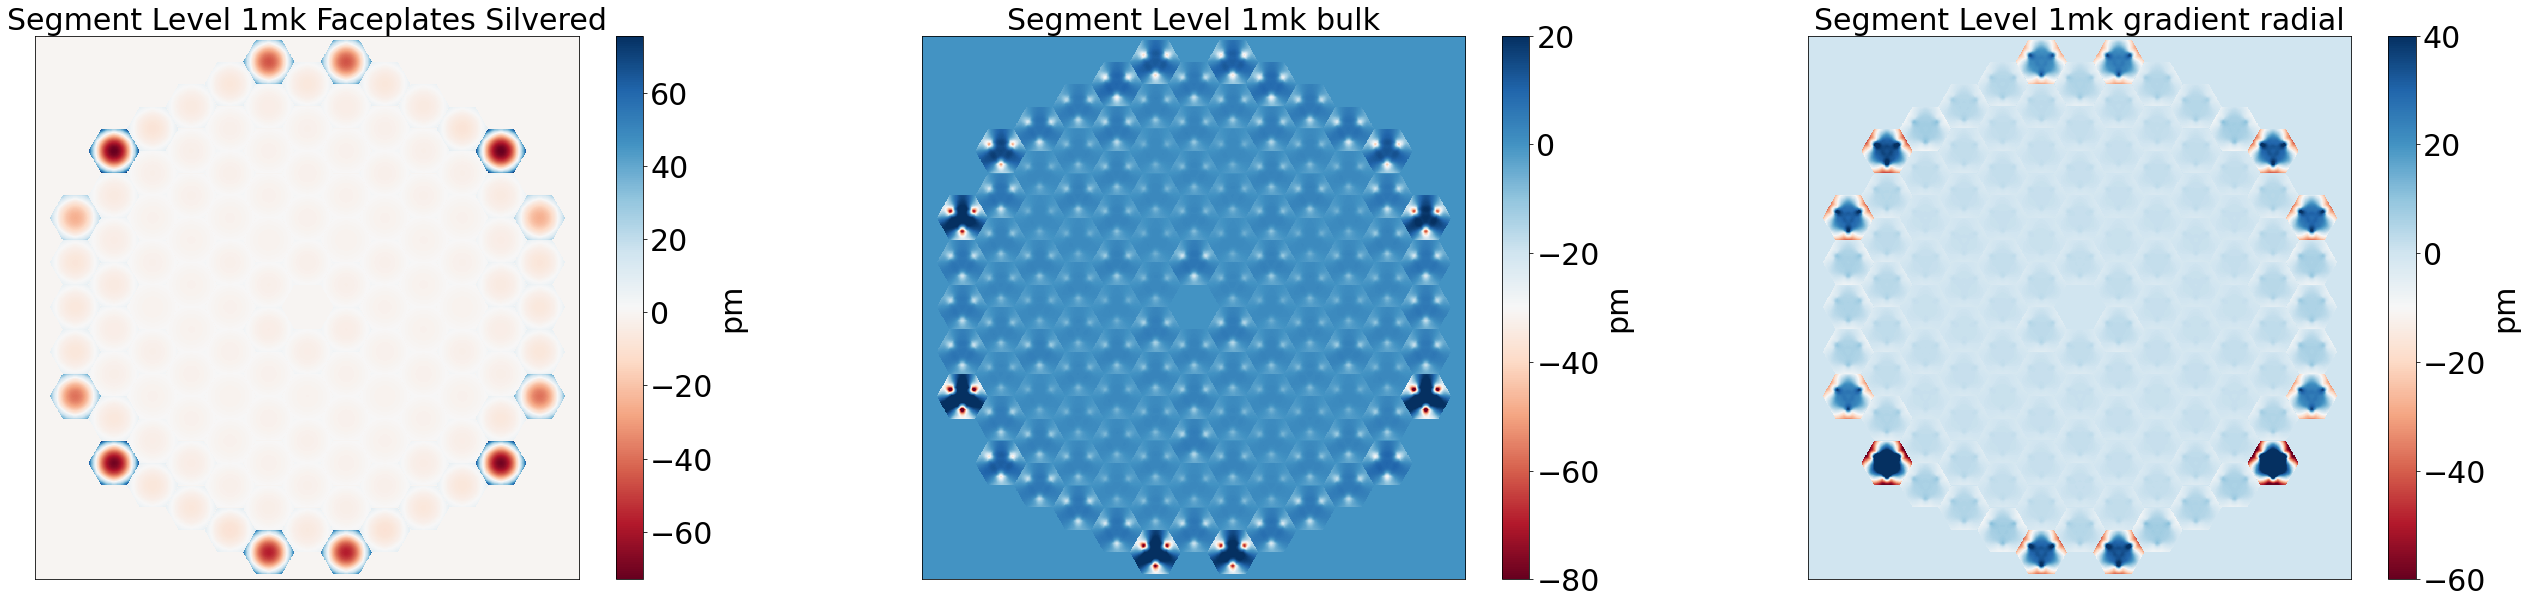

In [82]:
plt.figure(figsize=(45,10))

plt.subplot(1,3,1)
plt.title("Segment Level 1mk Faceplates Silvered", fontsize =30)
hcipy.imshow_field((nu_maps[0])*1e12, cmap = 'RdBu') #vmin = -45, vmax = 65
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm", fontsize =30)

plt.subplot(1,3,2)
plt.title("Segment Level 1mk bulk",fontsize =30)
hcipy.imshow_field((nu_maps[1])*1e12, cmap = 'RdBu',vmin = -80, vmax = 20)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm", fontsize =30)

plt.subplot(1,3,3)
plt.title("Segment Level 1mk gradient radial",fontsize =30)
hcipy.imshow_field((nu_maps[2])*1e12, cmap = 'RdBu',vmin = -60, vmax = 40)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)

plt.show()


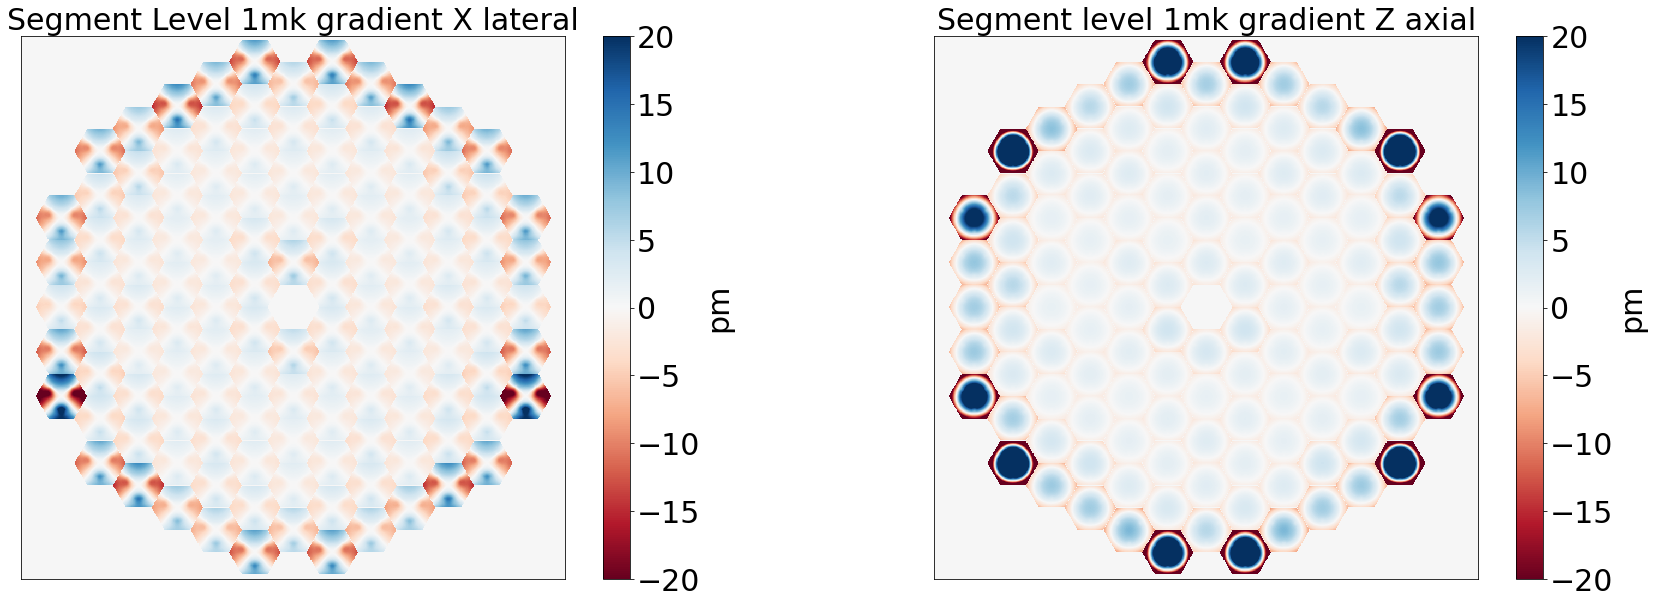

In [77]:
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.title("Segment Level 1mk gradient X lateral", fontsize=30)
hcipy.imshow_field((nu_maps[3])*1e12, cmap = 'RdBu',vmin = -20, vmax = 20)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)

plt.subplot(1,2,2)
plt.title("Segment level 1mk gradient Z axial",fontsize =30)
hcipy.imshow_field((nu_maps[4])*1e12,cmap = 'RdBu', vmin = -20, vmax = 20)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("pm",fontsize =30)

In [78]:
five_vec_1 = np.zeros(120)
five_vec_2 = np.zeros(120)
five_vec_3 = np.zeros(120)
five_vec_4 = np.zeros(120)
five_vec_5 = np.zeros(120)

j = -1
for i in range (0,596,5):
        j = j+1
        print("i---",i,"j---",j) 
        five_vec_1[j]=mu_map_harris[i]
        five_vec_2[j]=mu_map_harris[i+1]
        five_vec_3[j]=mu_map_harris[i+2]
        five_vec_4[j]=mu_map_harris[i+3]
        five_vec_5[j]=mu_map_harris[i+4]

i--- 0 j--- 0
i--- 5 j--- 1
i--- 10 j--- 2
i--- 15 j--- 3
i--- 20 j--- 4
i--- 25 j--- 5
i--- 30 j--- 6
i--- 35 j--- 7
i--- 40 j--- 8
i--- 45 j--- 9
i--- 50 j--- 10
i--- 55 j--- 11
i--- 60 j--- 12
i--- 65 j--- 13
i--- 70 j--- 14
i--- 75 j--- 15
i--- 80 j--- 16
i--- 85 j--- 17
i--- 90 j--- 18
i--- 95 j--- 19
i--- 100 j--- 20
i--- 105 j--- 21
i--- 110 j--- 22
i--- 115 j--- 23
i--- 120 j--- 24
i--- 125 j--- 25
i--- 130 j--- 26
i--- 135 j--- 27
i--- 140 j--- 28
i--- 145 j--- 29
i--- 150 j--- 30
i--- 155 j--- 31
i--- 160 j--- 32
i--- 165 j--- 33
i--- 170 j--- 34
i--- 175 j--- 35
i--- 180 j--- 36
i--- 185 j--- 37
i--- 190 j--- 38
i--- 195 j--- 39
i--- 200 j--- 40
i--- 205 j--- 41
i--- 210 j--- 42
i--- 215 j--- 43
i--- 220 j--- 44
i--- 225 j--- 45
i--- 230 j--- 46
i--- 235 j--- 47
i--- 240 j--- 48
i--- 245 j--- 49
i--- 250 j--- 50
i--- 255 j--- 51
i--- 260 j--- 52
i--- 265 j--- 53
i--- 270 j--- 54
i--- 275 j--- 55
i--- 280 j--- 56
i--- 285 j--- 57
i--- 290 j--- 58
i--- 295 j--- 59
i--- 300 j--

In [79]:
luvoir2 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir2.create_segmented_mirror(1)
luvoir2.sm.actuators = five_vec_1

luvoir3 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir3.create_segmented_mirror(1)
luvoir3.sm.actuators = five_vec_2

luvoir4 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir4.create_segmented_mirror(1)
luvoir4.sm.actuators = five_vec_3


luvoir5 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir5.create_segmented_mirror(1)
luvoir5.sm.actuators = five_vec_4


luvoir6 = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir6.create_segmented_mirror(1)
luvoir6.sm.actuators = five_vec_5

/opt/miniconda3/envs/pastis/lib/python3.7/site-packages/hcipy/field/cartesian_grid.py:74: UserWarning: No automatic weights could be calculated for this grid.
  self.weights *= np.abs(scale)**self.ndim


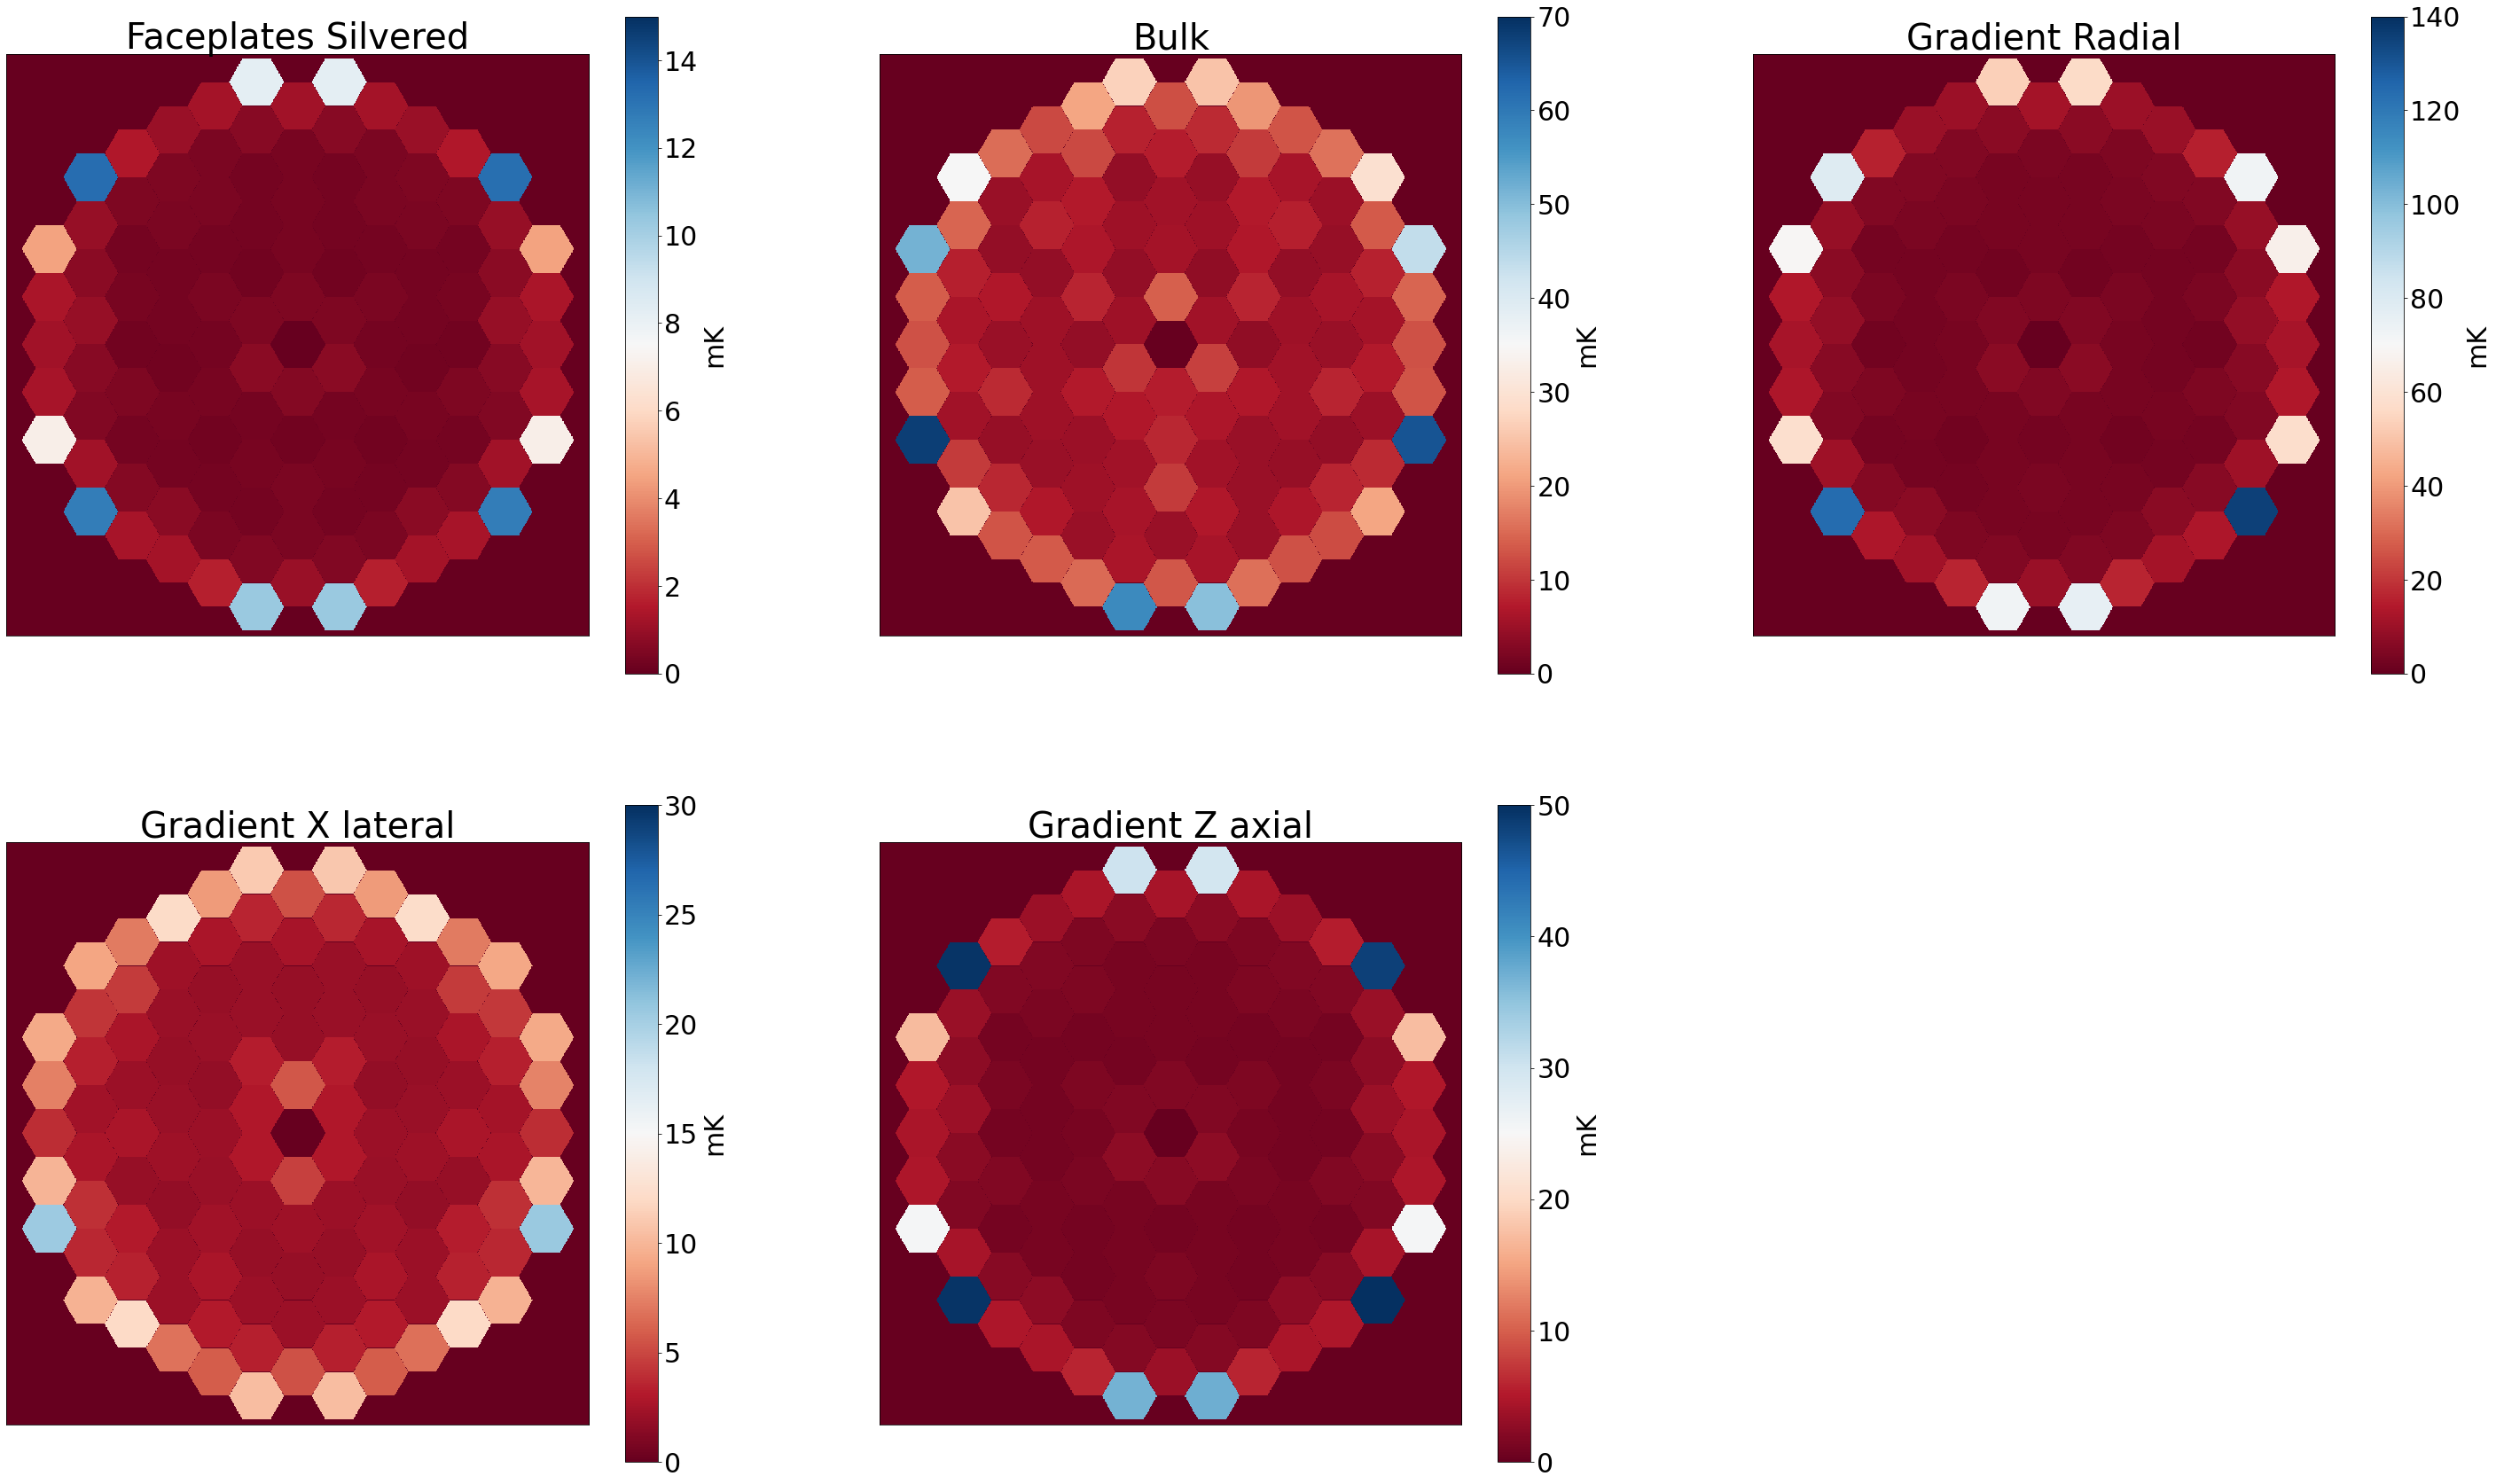

In [81]:
plt.figure(figsize =(50,30))

plt.subplot(2,3,1)
plt.title("Faceplates Silvered",fontsize=40)
hcipy.imshow_field((luvoir2.sm.surface)*1000, cmap = 'RdBu', vmin =0, vmax = 15) #this is a hack
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("mK",fontsize =30)

plt.subplot(2,3,2)
plt.title("Bulk",fontsize=40)
hcipy.imshow_field((luvoir3.sm.surface)*1000, cmap = 'RdBu',vmin =0, vmax = 70)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("mK",fontsize =30)

plt.subplot(2,3,3)
plt.title("Gradient Radial",fontsize=40)
hcipy.imshow_field((luvoir4.sm.surface)*1000, cmap = 'RdBu',vmin =0, vmax = 140)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = 30)
cbar.set_label("mK",fontsize =30)


plt.subplot(2,3,4)
plt.title("Gradient X lateral", fontsize=40)
hcipy.imshow_field((luvoir5.sm.surface)*1000, cmap = 'RdBu',vmin =0, vmax = 30)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = 30)
cbar.set_label("mK",fontsize =30)

plt.subplot(2,3,5)
plt.title("Gradient Z axial",fontsize =40)
hcipy.imshow_field((luvoir6.sm.surface)*1000, cmap = 'RdBu',vmin =0, vmax = 50)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = 30)
cbar.set_label("mK",fontsize =30)


In [80]:
print(np.min(five_vec_1)*1000, np.max(five_vec_1)*1000, np.mean(five_vec_1)*1000, np.std(five_vec_1)*1000, '\n')
print(np.min(five_vec_2)*1000, np.max(five_vec_2)*1000, np.mean(five_vec_2)*1000, np.std(five_vec_2)*1000, '\n')
print(np.min(five_vec_3)*1000, np.max(five_vec_3)*1000, np.mean(five_vec_3)*1000, np.std(five_vec_3)*1000, '\n')
print(np.min(five_vec_4)*1000, np.max(five_vec_4)*1000, np.mean(five_vec_4)*1000, np.std(five_vec_4)*1000, '\n')
print(np.min(five_vec_5)*1000, np.max(five_vec_5)*1000, np.mean(five_vec_5)*1000, np.std(five_vec_5)*1000, '\n')

0.2692321055663727 13.184567056325944 1.496968295407911 2.8094912755772525 

4.068517452130747 67.86220901075919 11.438879451583862 11.759811495668187 

2.621451279285431 135.24981532510108 13.162925902314127 22.881380475629193 

1.8456007538782888 20.508263606760476 4.451496661581138 3.576555496484425 

0.977016008246181 50.65090392555333 5.519814523073386 10.529471035593488 



## In mk/s

In [ ]:
delta_wf = 0.5 #unit less
t_wfs = 3 #in sec


plt.figure(figsize =(50,30))

plt.subplot(2,3,1)
plt.title("Faceplates Silvered",fontsize=30)
hcipy.imshow_field((luvoir2.sm.surface)*1000*delta_wf*(1/t_wfs), cmap = 'RdBu',vmin =0, vmax = 1.6)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("mK/s",fontsize =40)

plt.subplot(2,3,2)
plt.title("Bulk",fontsize=30)
hcipy.imshow_field((luvoir3.sm.surface)*1000*delta_wf*(1/t_wfs), cmap = 'RdBu',vmin =0, vmax = 8)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=30)
cbar.set_label("mK/s",fontsize =40)

plt.subplot(2,3,3)
plt.title("Gradient Radial",fontsize=30)
hcipy.imshow_field((luvoir4.sm.surface)*1000*delta_wf*(1/t_wfs), cmap = 'RdBu',vmin =0, vmax = 16)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = 30)
cbar.set_label("mK/s",fontsize =40)


plt.subplot(2,3,4)
plt.title("Gradient X lateral", fontsize=30)
hcipy.imshow_field((luvoir5.sm.surface)*1000*delta_wf*(1/t_wfs), cmap = 'RdBu',vmin =0, vmax = 2.5)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = 30)
cbar.set_label("mK/s",fontsize =40)

plt.subplot(2,3,5)
plt.title("Gradient Z axial",fontsize =30)
hcipy.imshow_field((luvoir6.sm.surface)*1000*delta_wf*(1/t_wfs), cmap = 'RdBu',vmin =0, vmax = 6)
plt.tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize = 30)
cbar.set_label("mK/s",fontsize =40)


plt.show()

In [ ]:
print(np.min(five_vec_1)*1000*delta_wf*(1/t_wfs), 
      np.max(five_vec_1)*1000*delta_wf*(1/t_wfs), np.mean(five_vec_1)*1000*delta_wf*(1/t_wfs)
      , np.std(five_vec_1)*1000*delta_wf*(1/t_wfs), '\n')
print(np.min(five_vec_2)*1000*delta_wf*(1/t_wfs), 
      np.max(five_vec_2)*1000*delta_wf*(1/t_wfs), np.mean(five_vec_2)*1000*delta_wf*(1/t_wfs)
      , np.std(five_vec_2)*1000*delta_wf*(1/t_wfs), '\n')
print(np.min(five_vec_3)*1000*delta_wf*(1/t_wfs), 
      np.max(five_vec_3)*1000*delta_wf*(1/t_wfs), np.mean(five_vec_3)*1000*delta_wf*(1/t_wfs)
      , np.std(five_vec_3)*1000*delta_wf*(1/t_wfs), '\n')
print(np.min(five_vec_4)*1000*delta_wf*(1/t_wfs), 
      np.max(five_vec_4)*1000*delta_wf*(1/t_wfs), np.mean(five_vec_4)*1000*delta_wf*(1/t_wfs)
      , np.std(five_vec_4)*1000*delta_wf*(1/t_wfs), '\n')
print(np.min(five_vec_5)*1000*delta_wf*(1/t_wfs), 
      np.max(five_vec_5)*1000*delta_wf*(1/t_wfs), np.mean(five_vec_5)*1000*delta_wf*(1/t_wfs)
      , np.std(five_vec_5)*1000*delta_wf*(1/t_wfs), '\n')

### Plotting intensity after poking each segment with harris mode

In [ ]:
luvoir_test = LuvoirA_APLC(optics_input, coronagraph_design, sampling)
luvoir_test.create_segmented_harris_mirror(filepath,pad_orientation, thermal = True,mechanical=False,other=False) 
luvoir_test.harris_sm

#harris_mode = np.zeros(n_harris)
#harris_mode[116] = nm_aber
#luvoir_test.harris_sm.actuators  = harris_mode
#hcipy.imshow_field(((10*luvoir_test.harris_sm.surface+5*1e-8*luvoir_segmented_pattern)))
#plt.colorbar()

In [ ]:
# from astropy.io import fits as pf
# import matplotlib.ticker as ticker

# del_contrast = []
# contrast_floor_aber = []

# for pp in range(0, 1):
#     #print(f'Working on mode {5*pp+4}',{pp})
    
#     # Apply calibration aberration to used mode
#     harris_mode = np.zeros(n_harris)
#     harris_mode[5*pp+4] = five_vec_5[pp]*1e-9 #m
#     luvoir_test.harris_sm.actuators  = harris_mode/2

#     #Calculate coronagraphic E-field and add to lists
#     aberrated_coro_psf_t, inter_t = luvoir_test.calc_psf(display_intermediate=False, return_intermediate='efield',norm_one_photon=True)
#     pupil_phase = np.zeros((1000,1000))
#     pupil_phase = np.array(np.reshape(inter_t['harris_seg_mirror'].phase,(1000,1000)))
#     focal_int = np.zeros((115,115))
#     focal_int = np.array(np.reshape(aberrated_coro_psf_t.amplitude,(115,115)))
#     focal_cont = (np.square(focal_int))/norm
#     #focal_int2 = np.square(focal_int) - (np.square(np.array(np.reshape(unaberrated_coro_psf,(115,115))))/norm)
    
#     dh_intensity2 = (((unaberrated_coro_psf))/norm)*luvoir_test.dh_mask
#     contrast_floor_aber2 = np.mean(dh_intensity2[np.where(luvoir_test.dh_mask != 0)])
#     dh_intensity = ((np.square(aberrated_coro_psf_t.amplitude))/ norm) * luvoir_test.dh_mask
#     contrast_floor_aber = np.mean(dh_intensity[np.where(luvoir_test.dh_mask != 0)])
#     delta_contrast = contrast_floor_aber-contrast_floor_aber2
#     print(contrast_floor_aber2, contrast_floor_aber, delta_contrast)
    
#     change = np.square(focal_cont) - (np.square(np.array(np.reshape(unaberrated_coro_psf,(115,115))))/norm)
    
    
#     image_diff = (np.square(aberrated_coro_psf_t.amplitude) - unaberrated_coro_psf)/norm
#     change_mean = np.mean(image_diff[np.where(luvoir_test.dh_mask != 0)])
#     print(change_mean)
    #del_contrast.append(delta)
    #contrast_floor_aber.append(contrast_floor_aber)
    
#     plt.figure(figsize=(14,5))
#     plt.subplot(1,3,1)
#     hcipy.imshow_field((inter_t['harris_seg_mirror']).phase, mask=luvoir_test.aperture, cmap='RdBu')
#     plt.title("Wavefront")
#     plt.colorbar()
    #cbar = plt.colorbar()
    #cbar.ax.tick_params(labelsize = 15)
    #cbar.set_label("radians",fontsize =15)


#     plt.subplot(1,3,2)
#     plt.imshow(np.log(focal_int2), cmap='RdBu')
#     plt.title("Aberrated Coronagraphic PSF")
#     plt.colorbar()
    
#     plt.subplot(1,3,3)
#     plt.imshow(np.log(focal_int2), cmap='RdBu')
#     plt.title("Aberrated Coronagraphic PSF")
#     plt.colorbar()
    #cbar = plt.colorbar()
    #cbar.formatter.set_powerlimits((-14, 14))
    #cbar.ax.tick_params(labelsize = 15)
    #cbar.set_label("contrast",fontsize =15)
    #print(type(pupil_phase), type(focal_int))
    #plt.savefig('/Users/asahoo/Desktop/data_repos/harris_data/ball_del_06/plot_%d.png'%pp)
    #pf.writeto('/Users/asahoo/Desktop/data_repos/harris_data/ball_del_06/pupil_%d.fits'%pp,pupil_phase)
    #pf.writeto('/Users/asahoo/Desktop/data_repos/harris_data/ball_del_06/change_%d.fits'%pp, change) #save delta


In [ ]:
1.6830731659218223e-14*600

In [ ]:
# plt.figure(figsize=(20,5))
# plt.title("Segment-based PASTIS constraints from PASTIS matrix and PASTIS modes")
# plt.plot((del_contrast))

## Plotting histograms 

In [ ]:
# n_harris = luvoir.harris_sm.num_actuators #int = 5*120 =600
# harris_mode =np.zeros(n_harris)
# luvoir.harris_sm.actuators = harris_mode

# unaber_e_field, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield', norm_one_photon=True)



## Uncorrelated, random draw of mu_map_harris, average intensity of peak, photon noise contrast

In [ ]:
#mu_map_harris?
#np.savetxt('/Users/asahoo/Desktop/data_repos/harris_data/mu_map.csv', mu_map_harris, delimiter=',')
#mu_map_harris = np.genfromtxt('/Users/asahoo/Desktop/data_repos/harris_data/mu_map.csv',delimiter=',')
#mu_map_harris

In [ ]:
all_contr_rand_seg1 = []
for rep in range(100):
    print('Segment realization {}/{}'.format(rep + 1, 50))
    
    harris_modes = np.zeros(n_harris)
    luvoir.harris_sm.actuators = harris_modes
    
    input_wf = luvoir.wf_aper
    harris_modes = np.random.normal(0,mu_map_harris*1e-9,n_harris)
    luvoir.harris_sm.actuators = harris_modes/2
    
    psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield', norm_one_photon=True)
    
    focal_int = np.zeros((115,115))
    focal_int = np.array(np.reshape(psf.amplitude,(115,115)))
    dh_intensity = ((np.square(psf.amplitude))/ norm) * luvoir.dh_mask
    contrast_floor_aber = np.mean(dh_intensity[np.where(luvoir.dh_mask != 0)]) - contrast_floor
    
    
    print(dh_intensity, contrast_floor_aber)
    all_contr_rand_seg1.append(contrast_floor_aber)
#     hcipy.imshow_field((inter['harris_seg_mirror']).phase, mask=luvoir_test.aperture, cmap='RdBu')
#     hcipy.imshow_field(np.log(np.square(aberrated_coro_psf_t.amplitude)), cmap='RdBu')

In [ ]:
tmp_std = np.dot(matrix_pastis,np.diag(mu_map_harris)**2)
var = 2*np.dot(tmp_std,tmp_std)
std = np.sqrt(np.trace(var))
c_mean_exp = np.mean(all_contr_rand_seg1)
c_std_exp = np.std(all_contr_rand_seg1)
print(std)

fig = plt.figure(figsize=(10,10))
plt.hist(np.log10(all_contr_rand_seg1),5)
plt.title('E2E raw contrast, {} realizations, target contrast 1e-11'.format(n_repeat), size=20)
plt.xlabel('Mean contrast in DH', size=20)
plt.xlim(-13,-9)
plt.ylabel('PDF', size=20)
plt.axvline(c_target, c='r', ls='-.', lw='3')
plt.axvline(c_target + std, c='b', ls=':', lw=4)
plt.axvline(c_target - std, c='b', ls=':', lw=4)
plt.axvline(c_mean_exp, c='orange', ls='-.', lw='3')
plt.axvline(c_mean_exp + c_std_exp, c='c', ls=':', lw=4)
plt.axvline(c_mean_exp - c_std_exp, c='c', ls=':', lw=4)
plt.tick_params(axis='both', which='both', length=6, width=2, labelsize=25)
#file_name = os.path.join(figures_path, f'{analysis_name}_MID_e2e_histogram.pdf')
#fig.savefig(file_name)

In [ ]:
plt.plot(all_contr_rand_seg1)
plt.ylabel("Delta Contrast")

## generate gif files 

In [ ]:
# import glob
# from PIL import Image

# # filepaths
# fp_in = "/Users/asahoo/Desktop/data_repos/harris_data/ball_del_01/*.png"
# fp_out = "/Users/asahoo/Desktop/data_repos/harris_data/image1.gif"

# # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
# img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
# img.save(fp=fp_out, format='GIF', append_images=imgs,
#          save_all=True, duration=200, loop=0)


In [ ]:
# tmp0 = np.abs(np.mean(focal_int_array,0) - np.reshape(unaberrated_coro_psf,[115,115]))
# tmp = np.abs(focal_int_array[1] - np.reshape(unaberrated_coro_psf,[115,115]))
# plt.imshow(np.log10(tmp))
# plt.colorbar()

In [ ]:
# contrast2D = np.sqrt(tmp0)/norm/np.sqrt(Nph*3600)
# contrast1D = np.reshape(contrast2D,[115**2])

In [ ]:
# np.mean(contrast1D[np.where(luvoir.dh_mask != 0)])

In [ ]:
1e-11/5.60647816e-13

In [ ]:
# plt.imshow(np.log10(contrast2D))
# plt.colorbar()

In [ ]:
# plt.imshow(np.log10(focal_int_array[0]))
# plt.colorbar()

### Uncorrelated case with Sine wave random realizations

In [ ]:
# alpha_wfs = 0.3
# t_wfs = 50 #secs from the close loop curve

n_trial = 50
focal_int_array_sin = np.zeros([n_trial,115,115])
all_contr_correlated_sin = []

for rep in range(n_trial):
    print('Segment realization {}/{}'.format(rep + 1, n_trial))
    
    harris_modes = mu_map_harris*1e-9*np.cos(2*np.pi/n_trial*rep)
    luvoir.harris_sm.actuators = harris_modes/2    #18
    
    psf, ref, inter = luvoir.calc_psf(ref=True, return_intermediate='efield', norm_one_photon=True)
    
    focal_int_sin = np.zeros((115,115))
    focal_int_sin = np.array(np.reshape(psf.intensity,(115,115)))
    focal_int_array_sin[rep] = focal_int_sin
    dh_intensity_sin = ((np.square(psf.amplitude))/ norm) * luvoir.dh_mask
    contrast_floor_aber_sin = np.mean(dh_intensity_sin[np.where(luvoir.dh_mask != 0)]) - contrast_floor
    
    print(contrast_floor_aber_sin)
    all_contr_correlated_sin.append(contrast_floor_aber_sin)

In [ ]:
 plt.plot(all_contr_correlated_sin)

In [ ]:
tmp0_sin = np.abs(np.mean(focal_int_array_sin,0) - np.reshape(unaberrated_coro_psf,[115,115]))
tmp_sin = np.abs(focal_int_array_sin[45] - np.reshape(unaberrated_coro_psf,[115,115]))
plt.imshow(np.log10(tmp_sin))
plt.colorbar()

In [ ]:
star_flux_6 = exoscene.star.bpgs_spectype_to_photonrate(spectype=sptype, Vmag=6, minlam=minlam.value, maxlam=maxlam.value)
Nph_6 = star_flux_6.value*15**2*np.sum(luvoir.apodizer**2) / npup**2

contrast2D_sin = np.sqrt(tmp0_sin)/norm/np.sqrt(Nph_6*60)
contrast1D_sin = np.reshape(contrast2D_sin,[115**2])

print(np.shape(contrast2D_sin), np.shape(contrast1D_sin))
print(np.mean(contrast1D_sin[np.where(luvoir.dh_mask != 0)]))


In [ ]:
1e-11/4.2289512666549787e-10

In [ ]:
plt.figure(figsize =(30,8))
plt.subplot(1,3,1)
plt.imshow(np.log10(tmp_sin))
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.log10(contrast2D_sin))
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.log10(focal_int_array_sin[0]))
plt.colorbar()

In [ ]:
# Nph?